1) Merging Datasets

In [ ]:
import pandas as pd
import numpy as np

# Step 1: Retrieve input datasets
# Define the file path for the crime dataset and load it into a DataFrame
crime_path = "/content/drive/MyDrive/ADT_Project/Major_Crime_Indicators_Open_Data_-3805566126367379926.csv"
crime_records = pd.read_csv(crime_path)  # Import the crime dataset for analysis

# Specify the weather dataset path (ensure this matches your actual file location)
weather_path = "/content/drive/MyDrive/ADT_Project/merge_wether_1.csv"
weather_info = pd.read_csv(weather_path)  # Load weather data into a separate DataFrame

# Step 2: Refine crime data
# Display initial values of the OCC_DATE column to inspect its format
print("Preview of original OCC_DATE entries:")
print(crime_records['OCC_DATE'].head())

# Convert OCC_DATE to a datetime object, handling any invalid entries gracefully
crime_records['OCC_DATE'] = pd.to_datetime(crime_records['OCC_DATE'], errors='coerce')  # 'coerce' turns errors into NaT

# Check for any missing dates after conversion and show a sample of the transformed data
print("\nTotal missing OCC_DATE entries after parsing:", crime_records['OCC_DATE'].isna().sum())  # Count NaT values
print("OCC_DATE entries after parsing (sample):")
print(crime_records['OCC_DATE'].head())  # Verify the datetime conversion worked

# Reformat the datetime objects into a string format (YYYY-MM-DD) for consistency
crime_records['OCC_DATE'] = crime_records['OCC_DATE'].dt.strftime('%Y-%m-%d')

# Show the reformatted dates to confirm the change
print("\nOCC_DATE entries post-reformatting:")
print(crime_records['OCC_DATE'].head())

# Step 3: Adjust weather data
# Rename the 'Date/Time' column to 'day_record' for easier merging later (assumes this column exists)
weather_info = weather_info.rename(columns={'Date/Time': 'day_record'})

# Convert the weather date column to datetime, ensuring proper parsing with the specified format
weather_info['day_record'] = pd.to_datetime(weather_info['day_record'], format='%Y-%m-%d', errors='coerce')

# Standardize the weather dates to YYYY-MM-DD strings to match the crime data
weather_info['day_record'] = weather_info['day_record'].dt.strftime('%Y-%m-%d')

# Step 4: Integrate datasets using date as the key
# Perform a left merge to combine crime and weather data, keeping all crime records
integrated_data = pd.merge(
    crime_records,          # Left DataFrame (crime data)
    weather_info,          # Right DataFrame (weather data)
    how='left',            # Keep all rows from crime_records, even if no weather match
    left_on='OCC_DATE',    # Column from crime data to match
    right_on='day_record'  # Column from weather data to match
)

# Step 5: Extract essential attributes
# List of crime-related columns to retain from the dataset
crime_attributes = [
    'OBJECTID', 'EVENT_UNIQUE_ID', 'REPORT_DATE', 'OCC_DATE', 'OCC_YEAR', 'OCC_MONTH',
    'OCC_DAY', 'OCC_DOW', 'OCC_HOUR', 'DIVISION', 'LOCATION_TYPE',
    'PREMISES_TYPE', 'UCR_CODE', 'UCR_EXT', 'OFFENCE', 'MCI_CATEGORY', 'HOOD_158',
    'NEIGHBOURHOOD_158', 'HOOD_140', 'NEIGHBOURHOOD_140', 'LONG_WGS84', 'LAT_WGS84'
]

# List of weather-related columns to include, focusing on temperature metrics
weather_attributes = [
    'day_record', 'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)'  # Only these weather details are needed
]

# Combine the attribute lists, excluding 'day_record' to avoid duplication with OCC_DATE
attributes_to_use = crime_attributes + [attr for attr in weather_attributes if attr != 'day_record']

# Filter the integrated dataset to include only the available specified attributes
attributes_to_use = [attr for attr in attributes_to_use if attr in integrated_data.columns]
integrated_data = integrated_data[attributes_to_use]  # Subset the DataFrame

# Step 6: Handle missing entries by substituting with zeros
# Replace any NaN values with 0 to ensure numerical consistency
integrated_data = integrated_data.fillna(0)

# Step 7: Exclude records with zero values in any field
# Remove rows where any column contains a zero, ensuring complete data
integrated_data = integrated_data[(integrated_data != 0).all(axis=1)]  # Keep only rows with no zeros

# Step 8: Store the resulting dataset
# Save the processed data to a CSV file in the specified directory
integrated_data.to_csv('/content/drive/MyDrive/ADT_Project/merged_crime_weather_2014.csv', index=False)  # No index column

# Step 9: Validate the output
# Display the first few rows of the final dataset for inspection
print("\nFirst few rows of the integrated dataset:")
print(integrated_data.head())

# Provide a summary of the dataset’s structure and data types
print("\nOverview of the integrated dataset:")
print(integrated_data.info())

# Create a secondary copy of the data and trigger a download for local use
integrated_data.to_csv('final_output.csv', index=False)  # Save as a new file
files.download('final_output.csv')  # Download the file (assumes a Colab environment)

Preview of original OCC_DATE entries:
0    12/31/2013 5:00:00 AM
1      1/1/2014 5:00:00 AM
2      1/1/2014 5:00:00 AM
3      1/1/2014 5:00:00 AM
4    12/31/2013 5:00:00 AM
Name: OCC_DATE, dtype: object

Total missing OCC_DATE entries after parsing: 0
OCC_DATE entries after parsing (sample):
0   2013-12-31 05:00:00
1   2014-01-01 05:00:00
2   2014-01-01 05:00:00
3   2014-01-01 05:00:00
4   2013-12-31 05:00:00
Name: OCC_DATE, dtype: datetime64[ns]

OCC_DATE entries post-reformatting:
0    2013-12-31
1    2014-01-01
2    2014-01-01
3    2014-01-01
4    2013-12-31
Name: OCC_DATE, dtype: object

First few rows of the integrated dataset:
   OBJECTID EVENT_UNIQUE_ID          REPORT_DATE    OCC_DATE  OCC_YEAR  \
1         2  GO-20141260715  1/1/2014 5:00:00 AM  2014-01-01    2014.0   
2         3  GO-20141260730  1/1/2014 5:00:00 AM  2014-01-01    2014.0   
3         4  GO-20141260597  1/1/2014 5:00:00 AM  2014-01-01    2014.0   
5         6  GO-20141260264  1/1/2014 5:00:00 AM  2014-01-01   

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2) Groupig according to temp and adding columns as seasons and Hot cold and Avg temp

In [ ]:
import pandas as pd

# Read the dataset (assuming it's in a CSV file)
df = pd.read_csv('/content/modified_dataset.csv')


# Function to determine season based on month
def get_season(month):
    if month in ['June', 'July', 'August']:
        return 'Summer'
    elif month in ['September', 'October', 'November']:
        return 'Fall'
    elif month in ['December', 'January', 'February', 'March', 'April', 'May']:
        return 'Winter'
    else:
        return 'Unknown'

# Function to determine overall temperature category
def get_temp_category(mean_temp):
    if mean_temp < 0:
        return 'Cold'
    elif 0 <= mean_temp <= 15:
        return 'Average'
    elif mean_temp > 15:
        return 'Hot'
    else:
        return 'Unknown'

# Add new columns
df['Season'] = df['OCC_MONTH'].apply(get_season)
df['Overall Temp'] = df['Mean Temp (°C)'].apply(get_temp_category)

# Display the first few rows to verify
print(df[['OCC_MONTH', 'Season', 'Mean Temp (°C)', 'Overall Temp']].head(10))

# Optional: Display the entire modified dataframe
# print(df.head())

# Optional: Save the modified dataset to a new CSV file
df.to_csv('modified_dataset.csv', index=False)
files.download('modified_dataset.csv')

3) Analysis of Dataset - 1

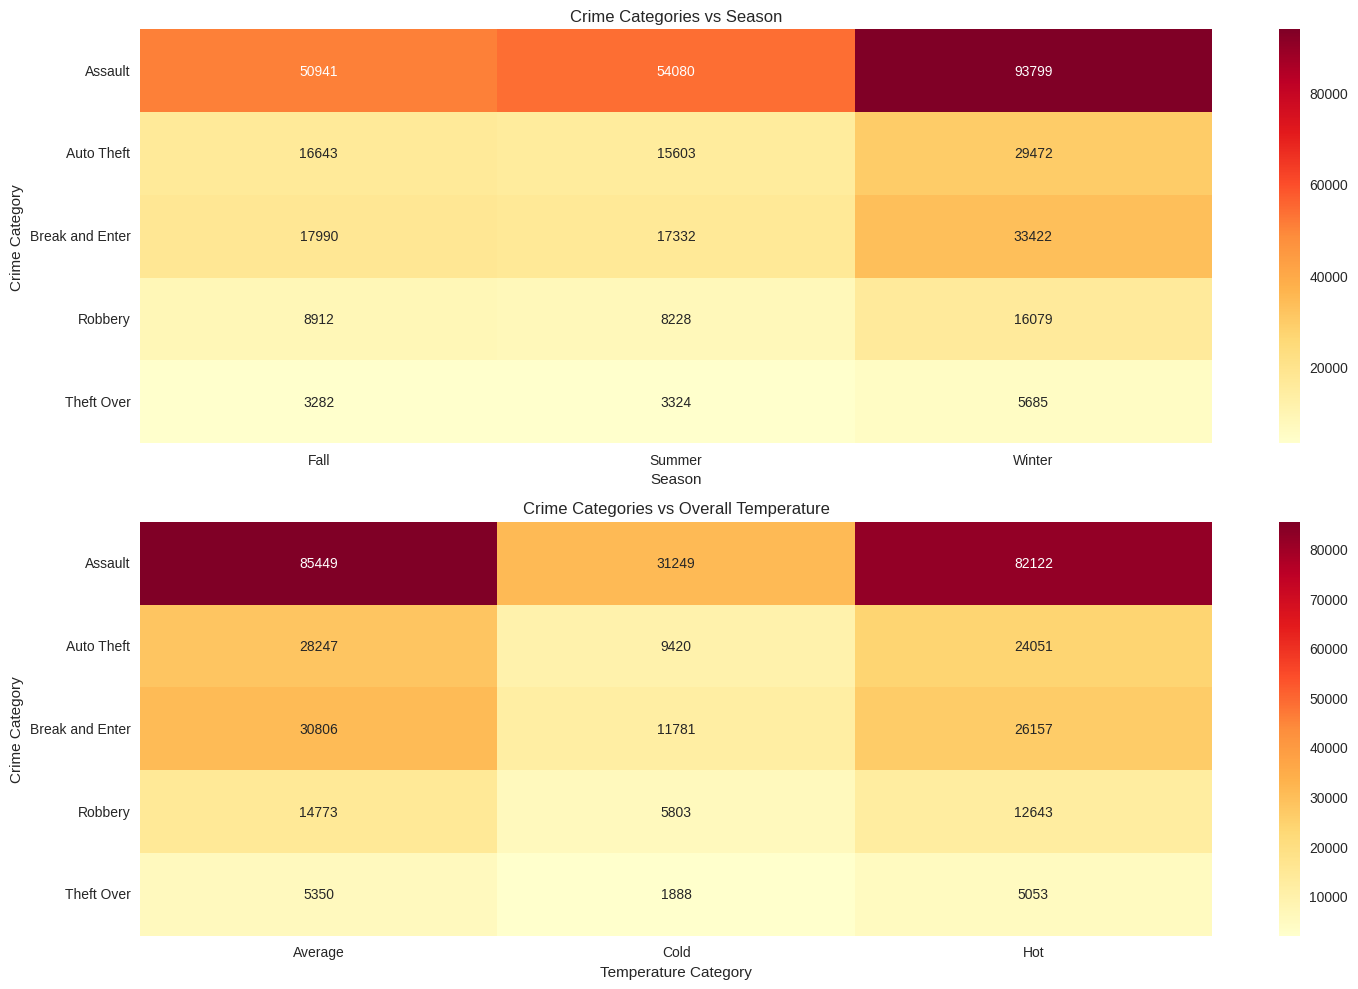

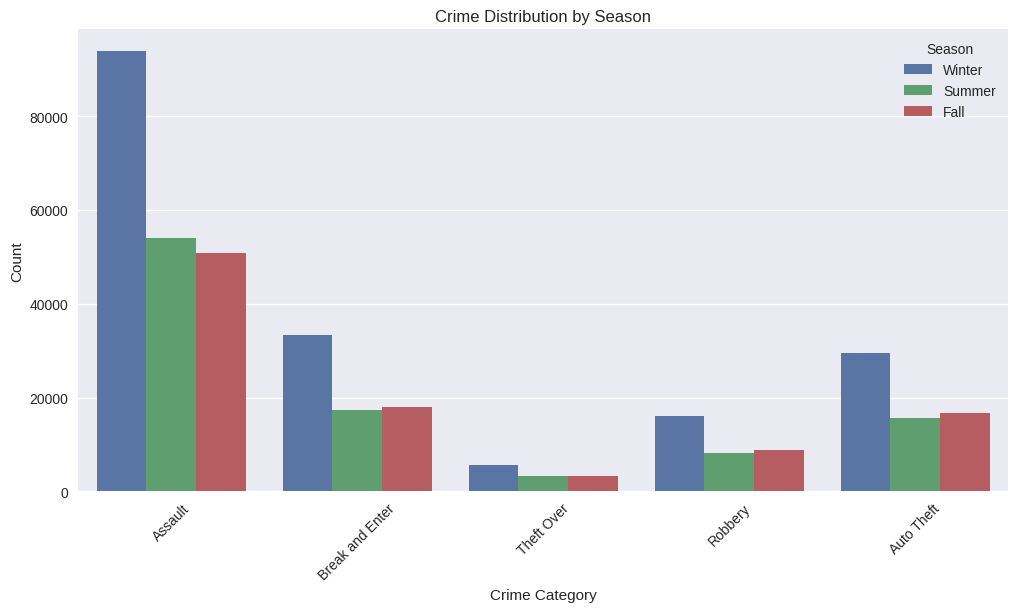

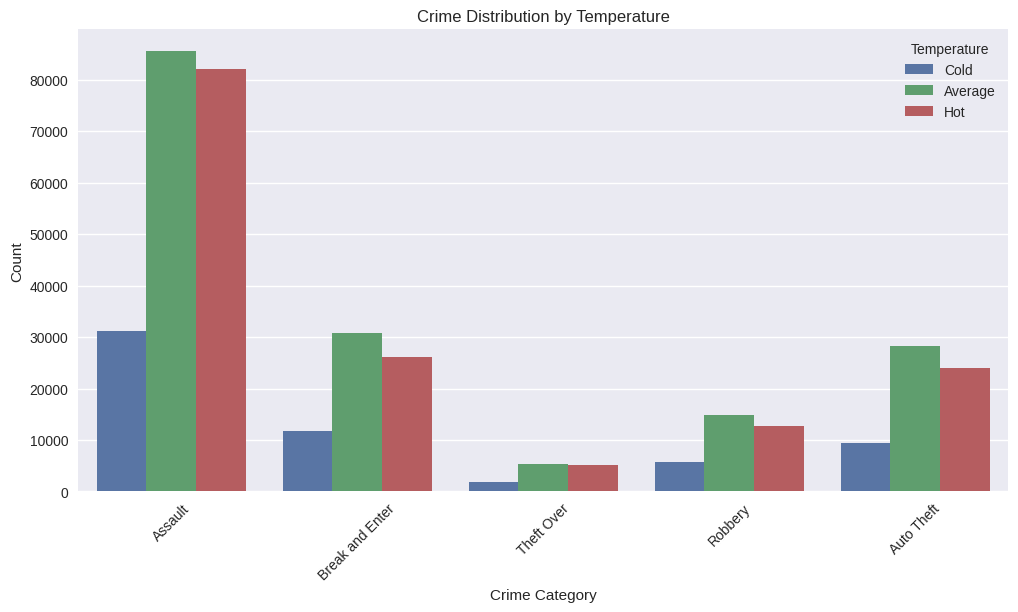

Correlation between Mean Temperature and Crime Count: 0.395

Crime Frequency by Season:
Season
Winter    47.614944
Summer    26.299121
Fall      26.085936
Name: proportion, dtype: float64

Crime Frequency by Temperature Category:
Overall Temp
Average    43.924363
Hot        40.029136
Cold       16.046500
Name: proportion, dtype: float64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive
from google.colab import drive
# drive.mount('/content/drive')

# Read the dataset
file_path = '/content/drive/MyDrive/ADT_Project/modified_dataset.csv'
df = pd.read_csv(file_path)

# 1. Count crimes by category and season
crime_season = pd.crosstab(df['MCI_CATEGORY'], df['Season'])

# 2. Count crimes by category and temperature
crime_temp = pd.crosstab(df['MCI_CATEGORY'], df['Overall Temp'])

# Set up the plotting style
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(15, 10))

# Plot 1: Crime Categories vs Season (Heatmap)
plt.subplot(2, 1, 1)
sns.heatmap(crime_season, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Crime Categories vs Season')
plt.xlabel('Season')
plt.ylabel('Crime Category')

# Plot 2: Crime Categories vs Overall Temperature (Heatmap)
plt.subplot(2, 1, 2)
sns.heatmap(crime_temp, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Crime Categories vs Overall Temperature')
plt.xlabel('Temperature Category')
plt.ylabel('Crime Category')

plt.tight_layout()
plt.show()

# Additional Bar Plot: Crime Distribution by Season
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='MCI_CATEGORY', hue='Season')
plt.title('Crime Distribution by Season')
plt.xlabel('Crime Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Season')
plt.show()

# Additional Bar Plot: Crime Distribution by Temperature
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='MCI_CATEGORY', hue='Overall Temp')
plt.title('Crime Distribution by Temperature')
plt.xlabel('Crime Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Temperature')
plt.show()

# Calculate correlation between numerical weather data and crime counts
crime_counts = df['MCI_CATEGORY'].value_counts().reset_index()
crime_counts.columns = ['MCI_CATEGORY', 'Count']

# Group by MCI_CATEGORY and calculate mean temperature
weather_correlation = df.groupby('MCI_CATEGORY').agg({
    'Mean Temp (°C)': 'mean'
}).reset_index()

# Merge with crime counts
weather_correlation = weather_correlation.merge(crime_counts, on='MCI_CATEGORY')

# Print correlation statistics
correlation = weather_correlation['Mean Temp (°C)'].corr(weather_correlation['Count'])
print(f"Correlation between Mean Temperature and Crime Count: {correlation:.3f}")

# Additional analysis: Crime frequency by season and temperature
print("\nCrime Frequency by Season:")
print(df['Season'].value_counts(normalize=True) * 100)
print("\nCrime Frequency by Temperature Category:")
print(df['Overall Temp'].value_counts(normalize=True) * 100)

4) Analysis of Dataset - 2

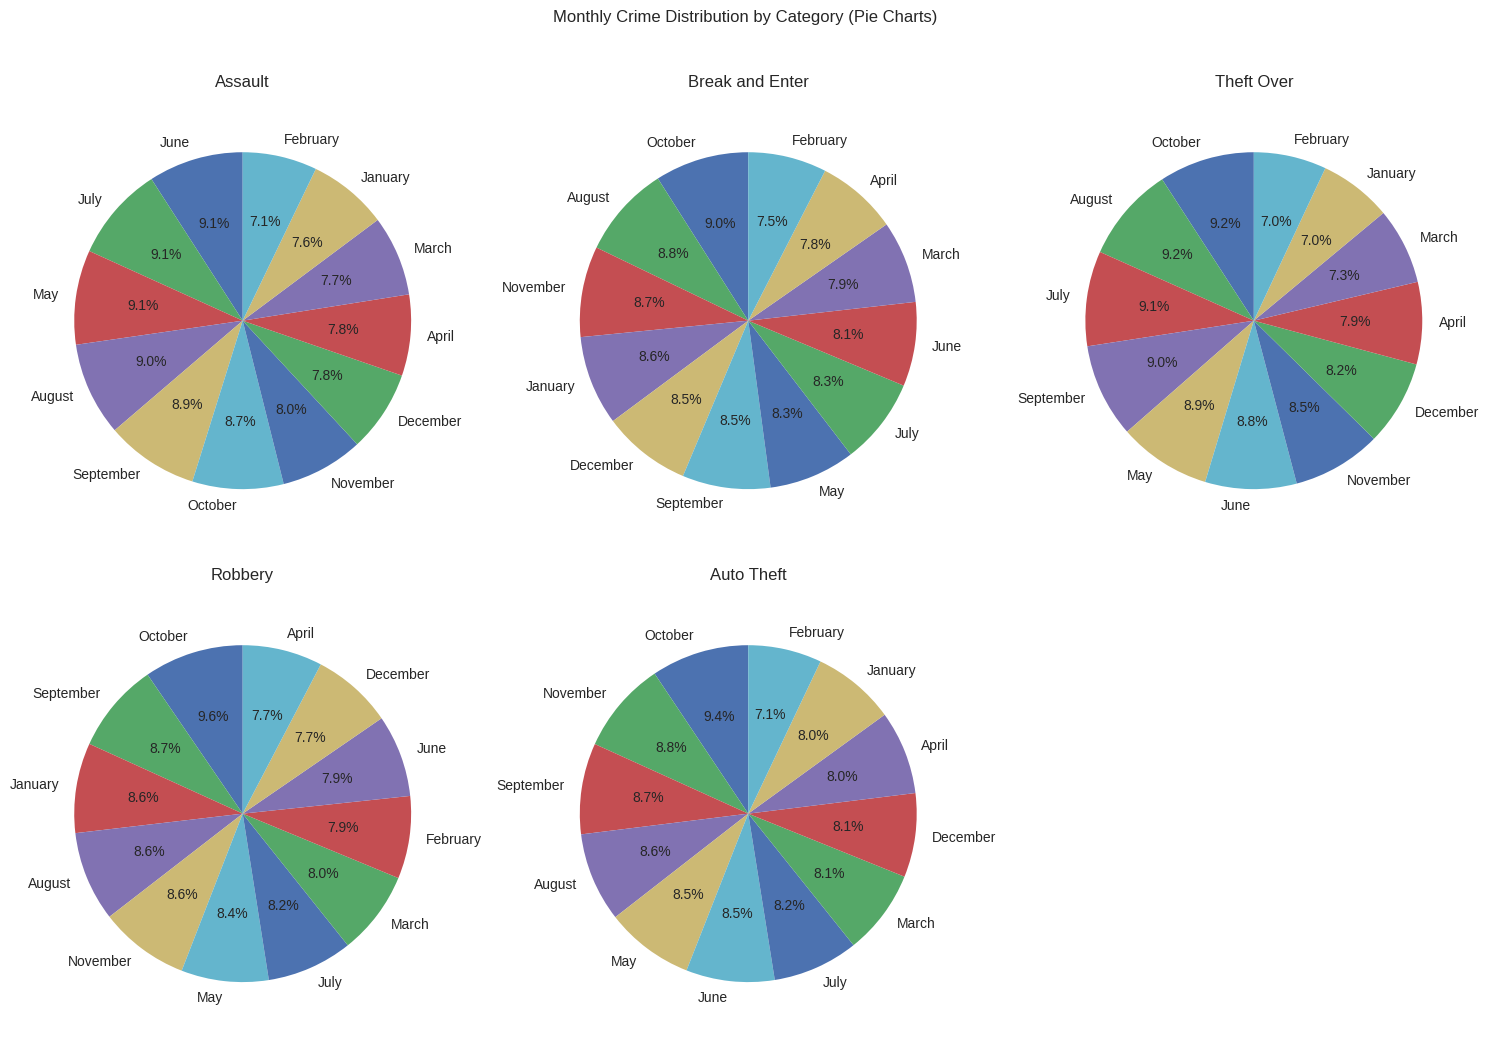


Monthly Statistics by Crime Category:

Assault:
           Mean Temp (°C)  Count
OCC_MONTH                       
January         -2.798941  15204
February        -2.141705  14214
March            1.939666  15313
April            7.787794  15484
May             15.064223  18031
June            19.947817  18115
July            22.841150  18107
August          22.169241  17858
September       18.878051  17700
October         12.077215  17389
November         5.459709  15852
December         1.091095  15553

Break and Enter:
           Mean Temp (°C)  Count
OCC_MONTH                       
January         -2.904905   5912
February        -2.250347   5184
March            1.786885   5429
April            7.719506   5347
May             14.672286   5701
June            19.763002   5557
July            22.741671   5697
August          22.031211   6078
September       18.686248   5810
October         11.848806   6196
November         5.167279   5984
December         1.186117   5849

Theft Ov

<ipython-input-3-7cac89f631e7>:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df[df['MCI_CATEGORY'] == category].groupby('OCC_MONTH').agg({
<ipython-input-3-7cac89f631e7>:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df[df['MCI_CATEGORY'] == category].groupby('OCC_MONTH').agg({
<ipython-input-3-7cac89f631e7>:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df[df['MCI_CATEGORY'] == category

           Mean Temp (°C)  Count
OCC_MONTH                       
January         -2.957367   2871
February        -2.361170   2632
March            1.407044   2669
April            7.699804   2549
May             14.896552   2784
June            19.748361   2624
July            22.573392   2736
August          22.031939   2868
September       18.893076   2874
October         11.870258   3174
November         5.309043   2864
December         1.113403   2574

Auto Theft:
           Mean Temp (°C)  Count
OCC_MONTH                       
January         -2.561884   4914
February        -1.526097   4353
March            2.227972   5030
April            7.957768   4956
May             14.864290   5245
June            19.897443   5240
July            22.870691   5077
August          22.047219   5286
September       18.630226   5396
October         12.050294   5792
November         5.378827   5455
December         1.334097   4974

Correlation between Monthly Mean Temperature and Crime Count b

<ipython-input-3-7cac89f631e7>:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df[df['MCI_CATEGORY'] == category].groupby('OCC_MONTH').agg({
<ipython-input-3-7cac89f631e7>:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_data = df[df['MCI_CATEGORY'] == category].groupby('OCC_MONTH').agg({


Break and Enter: 0.279
Theft Over: 0.879
Robbery: 0.224
Auto Theft: 0.524


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive
from google.colab import drive
# drive.mount('/content/drive')

# Read the dataset
file_path = '/content/drive/MyDrive/ADT_Project/modified_dataset.csv'
df = pd.read_csv(file_path)

# Ensure months are in correct order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
              'July', 'August', 'September', 'October', 'November', 'December']
df['OCC_MONTH'] = pd.Categorical(df['OCC_MONTH'], categories=month_order, ordered=True)

# Get unique crime categories
crime_categories = df['MCI_CATEGORY'].unique()

# 1. Pie Chart: Monthly Distribution for Each Crime Category
plt.figure(figsize=(15, 10))
for i, category in enumerate(crime_categories, 1):
    plt.subplot(2, 3, i)  # Adjust subplot grid based on number of categories
    category_data = df[df['MCI_CATEGORY'] == category]['OCC_MONTH'].value_counts()
    plt.pie(category_data, labels=category_data.index, autopct='%1.1f%%', startangle=90)
    plt.title(f'{category}')
    plt.axis('equal')
plt.tight_layout()
plt.suptitle('Monthly Crime Distribution by Category (Pie Charts)', y=1.05)
plt.show()

# Additional Analysis: Monthly statistics by crime category
print("\nMonthly Statistics by Crime Category:")
for category in crime_categories:
    print(f"\n{category}:")
    stats = df[df['MCI_CATEGORY'] == category].groupby('OCC_MONTH').agg({
        'Mean Temp (°C)': 'mean',
        'MCI_CATEGORY': 'count'
    }).rename(columns={'MCI_CATEGORY': 'Count'})
    print(stats)

# Correlation between monthly mean temperature and crime count by category
print("\nCorrelation between Monthly Mean Temperature and Crime Count by Category:")
for category in crime_categories:
    category_data = df[df['MCI_CATEGORY'] == category].groupby('OCC_MONTH').agg({
        'Mean Temp (°C)': 'mean',
        'MCI_CATEGORY': 'count'
    }).rename(columns={'MCI_CATEGORY': 'Count'})
    correlation = category_data['Mean Temp (°C)'].corr(category_data['Count'])
    print(f"{category}: {correlation:.3f}")

5) Analysis of dataset - 3 (Heat map)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Available columns in your dataset:
['OBJECTID', 'EVENT_UNIQUE_ID', 'REPORT_DATE', 'OCC_DATE', 'OCC_YEAR', 'OCC_MONTH', 'OCC_DAY', 'OCC_DOW', 'OCC_HOUR', 'DIVISION', 'LOCATION_TYPE', 'PREMISES_TYPE', 'UCR_CODE', 'UCR_EXT', 'OFFENCE', 'MCI_CATEGORY', 'HOOD_158', 'NEIGHBOURHOOD_158', 'HOOD_140', 'NEIGHBOURHOOD_140', 'LONG_WGS84', 'LAT_WGS84', 'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)', 'Season', 'Overall Temp']
Generating heatmaps for Assault
Heatmap saved: /content/drive/MyDrive/heatmap_Assault_January.html
Heatmap saved: /content/drive/MyDrive/heatmap_Assault_February.html
Heatmap saved: /content/drive/MyDrive/heatmap_Assault_March.html
Heatmap saved: /content/drive/MyDrive/heatmap_Assault_April.html
Heatmap saved: /content/drive/MyDrive/heatmap_Assault_May.html
Heatmap saved: /content/drive/MyDrive/heatmap_Assault_June.html
Heatmap saved: /content/dri

<ipython-input-4-bdc36fe3cbda>:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_category_stats = df.groupby(['OCC_MONTH', 'MCI_CATEGORY']).agg({


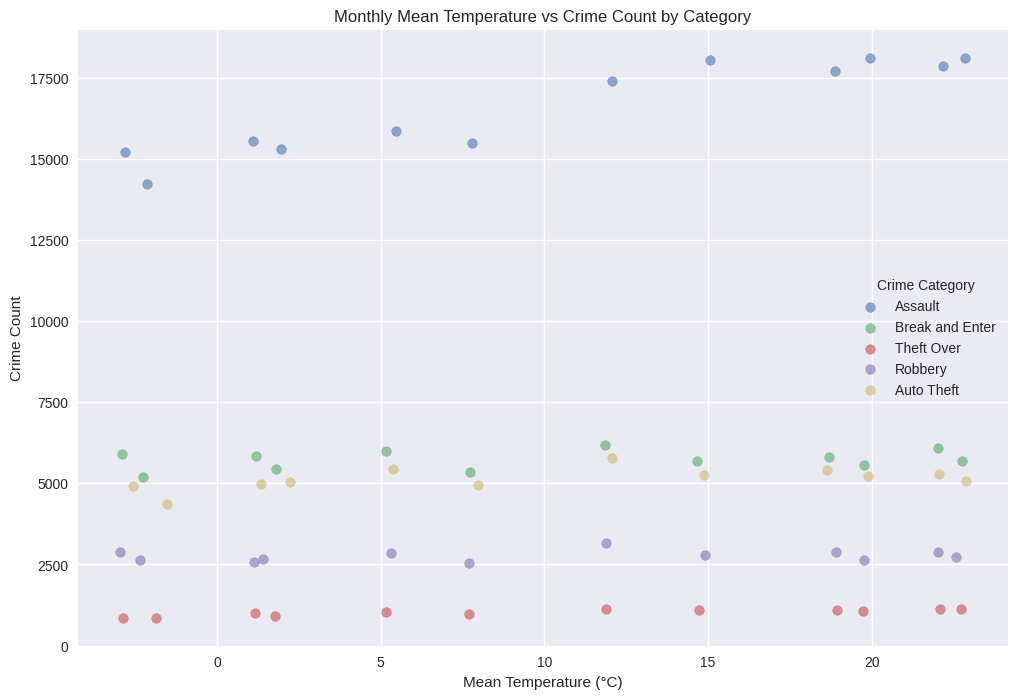

<ipython-input-4-bdc36fe3cbda>:86: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_temp = df.groupby('OCC_MONTH')['Mean Temp (°C)'].mean()


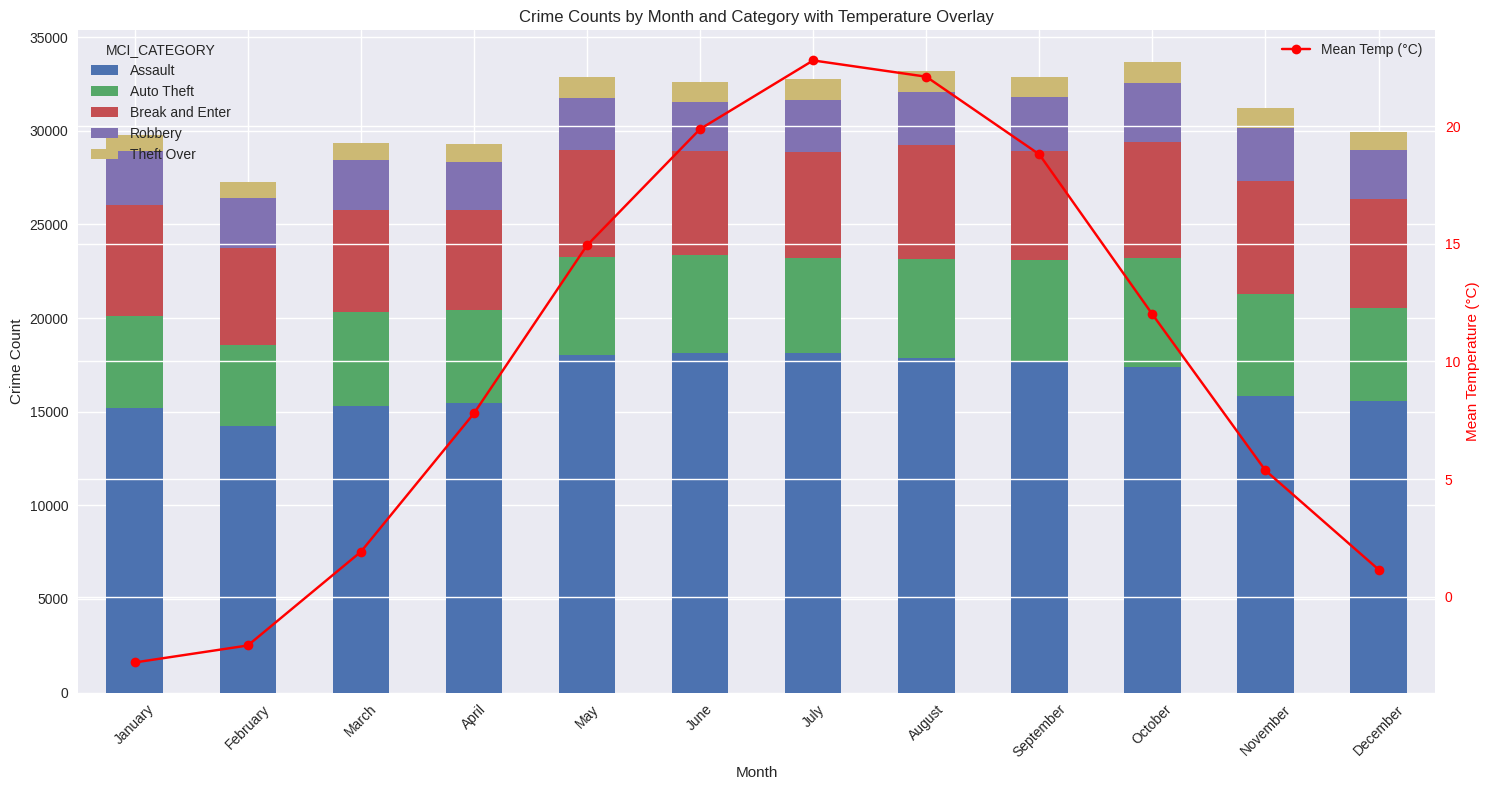


Correlation between Monthly Mean Temperature and Crime Count by Category:
Assault: 0.944
Break and Enter: 0.279
Theft Over: 0.879
Robbery: 0.224
Auto Theft: 0.524


In [ ]:
import pandas as pd
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Read the dataset
file_path = '/content/drive/MyDrive/ADT_Project/modified_dataset.csv'
df = pd.read_csv(file_path)

# Print column names to help identify coordinates
print("Available columns in your dataset:")
print(df.columns.tolist())

# Ensure months are in correct order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
              'July', 'August', 'September', 'October', 'November', 'December']
df['OCC_MONTH'] = pd.Categorical(df['OCC_MONTH'], categories=month_order, ordered=True)

# Replace these with your actual column names after checking df.columns
lat_col = 'LAT_WGS84'  # UPDATE THIS (e.g., 'Lat', 'LAT_WGS84', 'Y')
lon_col = 'LONG_WGS84'  # UPDATE THIS (e.g., 'Lon', 'LONG_WGS84', 'X')

# Check if the columns exist
if lat_col not in df.columns or lon_col not in df.columns:
    raise KeyError(f"Coordinate columns '{lat_col}' or '{lon_col}' not found in dataset. Please update lat_col and lon_col.")

# Get unique crime categories
crime_categories = df['MCI_CATEGORY'].unique()

# Center of Toronto for map initialization
toronto_center = [43.70, -79.42]

# Function to create heatmap
def create_heatmap(month, category, df_subset):
    data = df_subset[(df_subset['OCC_MONTH'] == month) & (df_subset['MCI_CATEGORY'] == category)]
    m = folium.Map(location=toronto_center, zoom_start=11, tiles='OpenStreetMap')
    heat_data = [[row[lat_col], row[lon_col]] for index, row in data.iterrows()
                if pd.notnull(row[lat_col]) and pd.notnull(row[lon_col])]
    HeatMap(heat_data, radius=15, blur=20, max_zoom=13).add_to(m)
    output_file = f'/content/drive/MyDrive/heatmap_{category}_{month}.html'
    m.save(output_file)
    return output_file

# Generate heatmaps
for category in crime_categories:
    print(f"Generating heatmaps for {category}")
    for month in month_order:
        output = create_heatmap(month, category, df)
        print(f"Heatmap saved: {output}")

# Analysis: Relate with weather and temperature
monthly_category_stats = df.groupby(['OCC_MONTH', 'MCI_CATEGORY']).agg({
    'Mean Temp (°C)': 'mean',
    lat_col: 'count'  # Using latitude count as proxy for crime count
}).rename(columns={lat_col: 'Crime Count'}).reset_index()

# Scatter Plot: Temperature vs Crime Count by Category
plt.figure(figsize=(12, 8))
for category in crime_categories:
    cat_data = monthly_category_stats[monthly_category_stats['MCI_CATEGORY'] == category]
    plt.scatter(cat_data['Mean Temp (°C)'], cat_data['Crime Count'],
                label=category, alpha=0.6)
plt.title('Monthly Mean Temperature vs Crime Count by Category')
plt.xlabel('Mean Temperature (°C)')
plt.ylabel('Crime Count')
plt.legend(title='Crime Category')
plt.grid(True)
plt.show()

# Bar Plot: Crime Counts by Month and Category with Temperature Overlay
fig, ax1 = plt.subplots(figsize=(15, 8))
crime_by_month = pd.crosstab(df['OCC_MONTH'], df['MCI_CATEGORY'])
crime_by_month.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title('Crime Counts by Month and Category with Temperature Overlay')
ax1.set_xlabel('Month')
ax1.set_ylabel('Crime Count')
ax1.tick_params(axis='x', rotation=45)

# Temperature overlay
ax2 = ax1.twinx()
monthly_temp = df.groupby('OCC_MONTH')['Mean Temp (°C)'].mean()
ax2.plot(monthly_temp.index, monthly_temp.values, color='red', marker='o', label='Mean Temp (°C)')
ax2.set_ylabel('Mean Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Correlation by category
print("\nCorrelation between Monthly Mean Temperature and Crime Count by Category:")
for category in crime_categories:
    cat_data = monthly_category_stats[monthly_category_stats['MCI_CATEGORY'] == category]
    correlation = cat_data['Mean Temp (°C)'].corr(cat_data['Crime Count'])
    print(f"{category}: {correlation:.3f}")

6) Use of Different Models to predict the outcome for each Category



Training Random Forest...
Training XGBoost...
Training SARIMAX...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS wil

Training LSTM...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.2179
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1867 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1455
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1022
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0714
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0515
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0422
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0432
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0381
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0340
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0313
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0310
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0339
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0332
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0302
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/valida

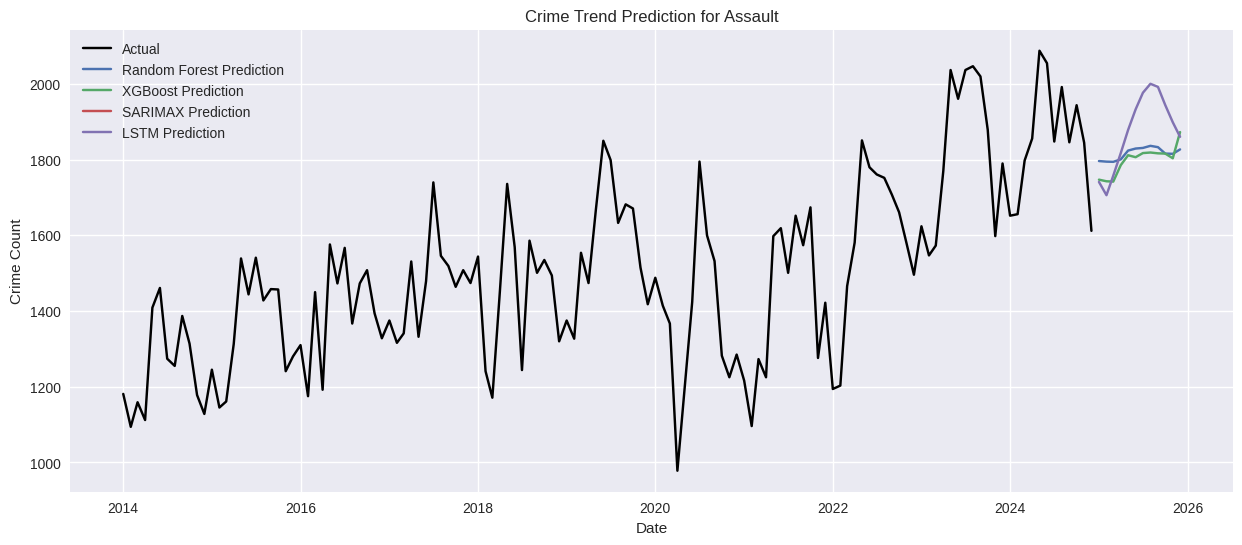

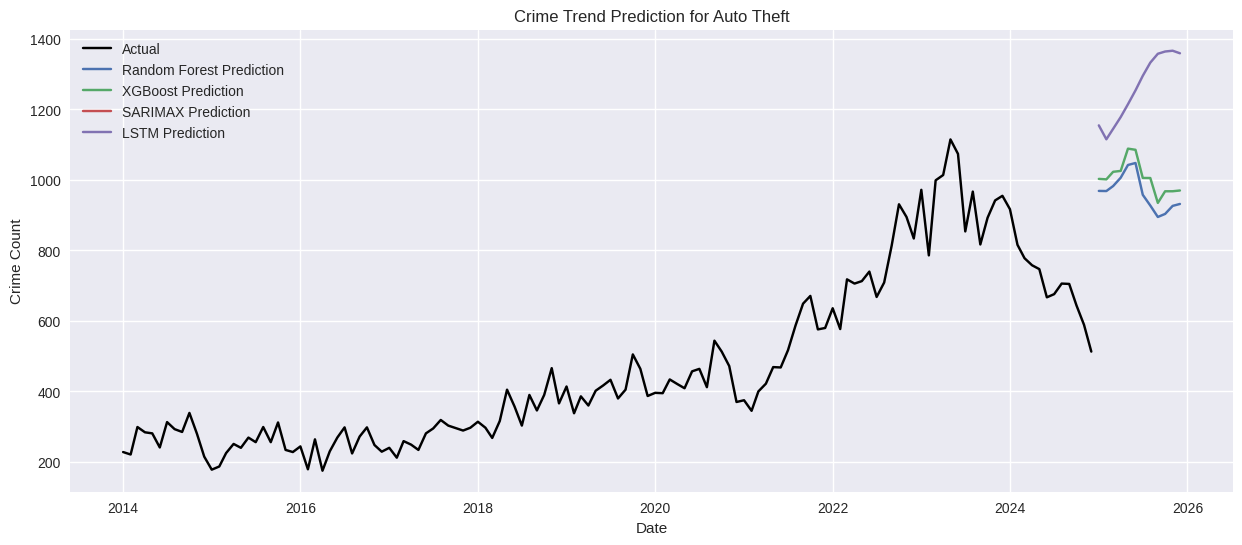

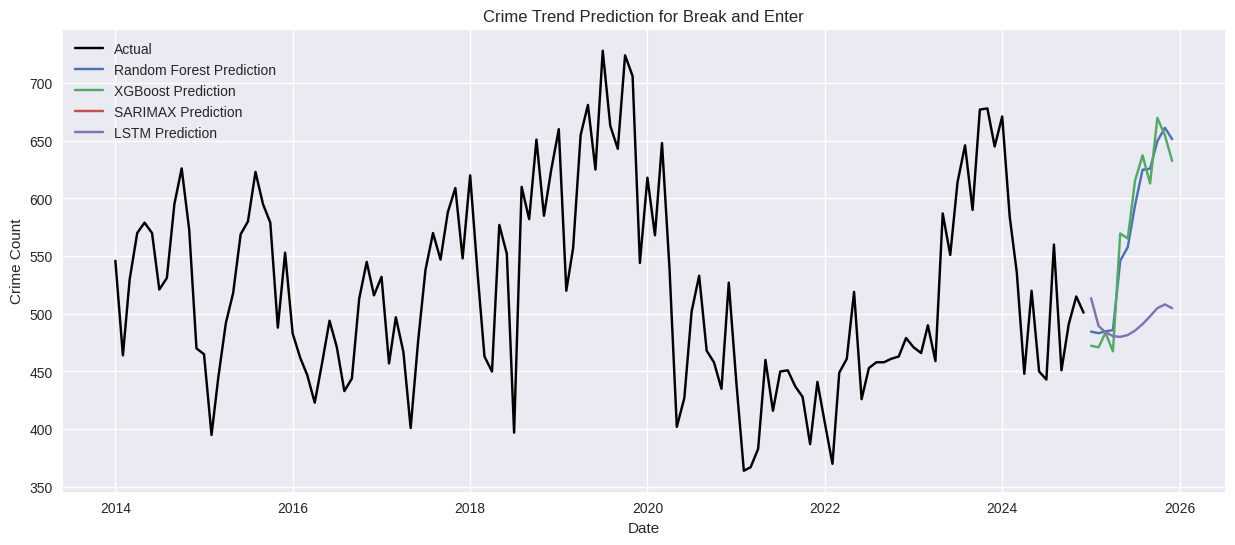

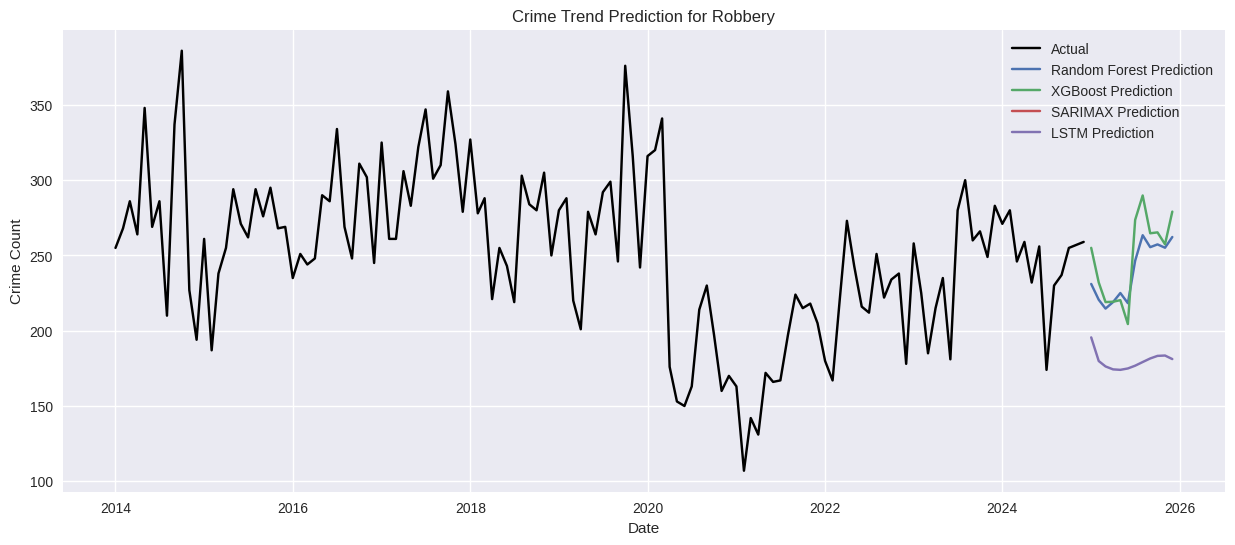

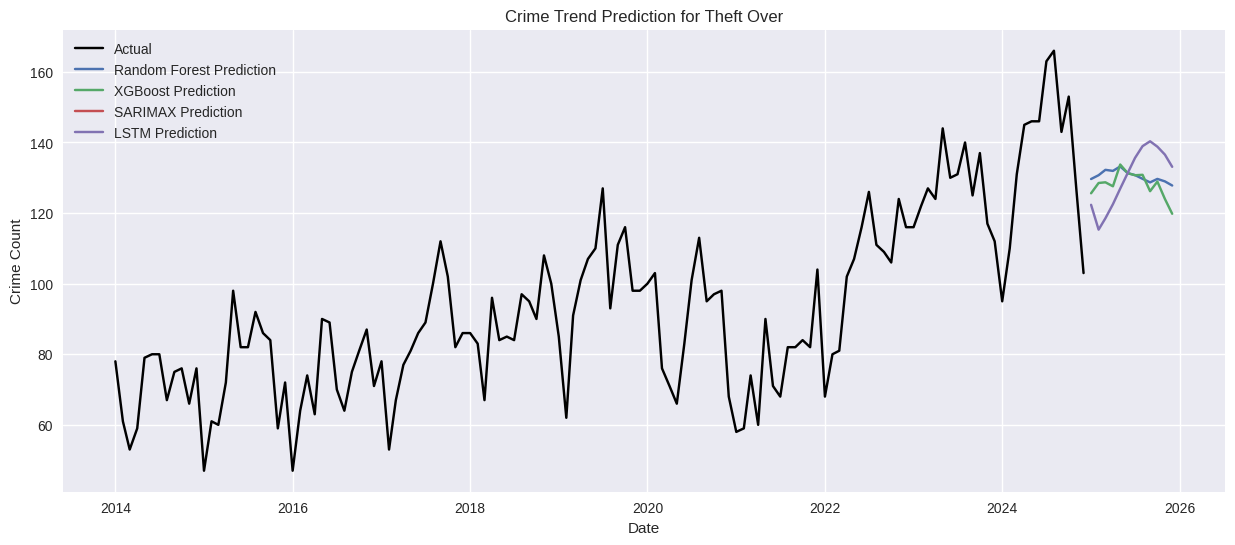


Mean Absolute Error (MAE) for Each Model by Category:
RF_Assault: 108.62
RF_Auto Theft: 247.25
RF_Break and Enter: 111.94
RF_Robbery: 32.00
RF_Theft Over: 16.40
XGB_Assault: 106.50
XGB_Auto Theft: 232.08
XGB_Break and Enter: 119.03
XGB_Robbery: 37.46
XGB_Theft Over: 15.04
SARIMAX_Assault: 121.46
SARIMAX_Auto Theft: 304.02
SARIMAX_Break and Enter: 111.46
SARIMAX_Robbery: 29.72
SARIMAX_Theft Over: 22.26
LSTM_Assault: 98.00
LSTM_Auto Theft: 391.21
LSTM_Break and Enter: 54.08
LSTM_Robbery: 57.97
LSTM_Theft Over: 17.57


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive

# Mount Google Drive
# drive.mount('/content/drive', force_remount=True)

# Read the dataset
file_path = '/content/drive/MyDrive/ADT_Project/modified_dataset.csv'
df = pd.read_csv(file_path)

# Ensure months are in correct order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df['OCC_MONTH'] = pd.Categorical(df['OCC_MONTH'], categories=month_order, ordered=True)

# Convert OCC_YEAR to integer
df['OCC_YEAR'] = df['OCC_YEAR'].astype(int)

# Create Date column
df['Date'] = pd.to_datetime(df['OCC_YEAR'].astype(str) + '-' +
                           df['OCC_MONTH'].astype(str).map(lambda x: f"{month_order.index(x)+1:02d}") + '-01')

# Aggregate data
agg_data = df.groupby(['Date', 'MCI_CATEGORY']).agg({'Mean Temp (°C)': 'mean', 'OBJECTID': 'count'}).rename(columns={'OBJECTID': 'Crime Count'}).reset_index()
crime_ts = agg_data.pivot(index='Date', columns='MCI_CATEGORY', values='Crime Count').fillna(0)
temp_ts = agg_data.groupby('Date')['Mean Temp (°C)'].mean()

# Split data
train_data = crime_ts[:-12]
test_data = crime_ts[-12:]
train_temp = temp_ts[:-12]
test_temp = temp_ts[-12:]

# Prepare future dates
last_date = crime_ts.index[-1]
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=12, freq='MS')
future_temp = temp_ts[-12:].mean()  # Average temp for future

# Store predictions and accuracies
predictions = {}
accuracies = {}

# 1. Random Forest
print("Training Random Forest...")
rf_preds = {}
for category in crime_ts.columns:
    X_train = pd.DataFrame({'Year': train_data.index.year, 'Month': train_data.index.month, 'Temp': train_temp})
    y_train = train_data[category]
    X_test = pd.DataFrame({'Year': test_data.index.year, 'Month': test_data.index.month, 'Temp': test_temp})
    X_future = pd.DataFrame({'Year': future_dates.year, 'Month': future_dates.month, 'Temp': [future_temp] * 12})

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    rf_test_pred = rf.predict(X_test)
    rf_future_pred = rf.predict(X_future)
    rf_preds[category] = rf_future_pred
    accuracies[f'RF_{category}'] = mean_absolute_error(test_data[category], rf_test_pred)
predictions['Random Forest'] = pd.DataFrame(rf_preds, index=future_dates)

# 2. XGBoost
print("Training XGBoost...")
xgb_preds = {}
for category in crime_ts.columns:
    X_train = pd.DataFrame({'Year': train_data.index.year, 'Month': train_data.index.month, 'Temp': train_temp})
    y_train = train_data[category]
    X_test = pd.DataFrame({'Year': test_data.index.year, 'Month': test_data.index.month, 'Temp': test_temp})
    X_future = pd.DataFrame({'Year': future_dates.year, 'Month': future_dates.month, 'Temp': [future_temp] * 12})

    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    xgb_model.fit(X_train, y_train)
    xgb_test_pred = xgb_model.predict(X_test)
    xgb_future_pred = xgb_model.predict(X_future)
    xgb_preds[category] = xgb_future_pred
    accuracies[f'XGB_{category}'] = mean_absolute_error(test_data[category], xgb_test_pred)
predictions['XGBoost'] = pd.DataFrame(xgb_preds, index=future_dates)

# 3. SARIMAX
print("Training SARIMAX...")
sarimax_preds = {}
for category in crime_ts.columns:
    model = SARIMAX(train_data[category], exog=train_temp, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results = model.fit(disp=False)
    sarimax_test_pred = results.predict(start=len(train_data), end=len(train_data)+11, exog=test_temp)
    sarimax_future_pred = results.forecast(steps=12, exog=[future_temp] * 12)
    sarimax_preds[category] = sarimax_future_pred
    accuracies[f'SARIMAX_{category}'] = mean_absolute_error(test_data[category], sarimax_test_pred)
predictions['SARIMAX'] = pd.DataFrame(sarimax_preds, index=future_dates)

# 4. Improved LSTM
print("Training LSTM...")
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Prepare data
X_data = pd.DataFrame({'Temp': temp_ts, 'Year': crime_ts.index.year, 'Month': crime_ts.index.month})
X_scaled = scaler_X.fit_transform(X_data)
y_scaled = scaler_y.fit_transform(crime_ts)

# Create sequences
sequence_length = 12
X_lstm, y_lstm = [], []
for i in range(sequence_length, len(X_scaled)):
    X_lstm.append(X_scaled[i-sequence_length:i])
    y_lstm.append(y_scaled[i])
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Split
train_size = len(X_lstm) - 12
X_train, X_test = X_lstm[:train_size], X_lstm[train_size:]
y_train, y_test = y_lstm[:train_size], y_lstm[train_size:]

# Build improved LSTM
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(sequence_length, X_train.shape[2]), return_sequences=True))
model.add(LSTM(50, activation='relu'))
model.add(Dense(len(crime_ts.columns)))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Test prediction
lstm_test_pred = scaler_y.inverse_transform(model.predict(X_test, verbose=0))

# Future prediction with rolling window
lstm_future_pred = []
last_sequence = X_lstm[-1].copy()
for _ in range(12):
    pred = model.predict(last_sequence.reshape(1, sequence_length, X_train.shape[2]), verbose=0)
    lstm_future_pred.append(pred[0])

    # Update sequence: shift left, add new prediction
    new_input = np.zeros((1, X_train.shape[2]))
    new_input[0, 0] = future_temp  # Temperature
    new_input[0, 1] = future_dates[_].year  # Year
    new_input[0, 2] = future_dates[_].month  # Month
    new_input = scaler_X.transform(new_input)
    last_sequence = np.vstack([last_sequence[1:], new_input])

lstm_future_pred = scaler_y.inverse_transform(np.array(lstm_future_pred))

# Store LSTM results
for i, category in enumerate(crime_ts.columns):
    accuracies[f'LSTM_{category}'] = mean_absolute_error(test_data[category], lstm_test_pred[:, i])
predictions['LSTM'] = pd.DataFrame(lstm_future_pred, columns=crime_ts.columns, index=future_dates)

# Plotting Predictions vs Actual
for category in crime_ts.columns:
    plt.figure(figsize=(15, 6))
    plt.plot(crime_ts.index, crime_ts[category], label='Actual', color='black')
    for model_name, pred_df in predictions.items():
        plt.plot(pred_df.index, pred_df[category], label=f'{model_name} Prediction')
    plt.title(f'Crime Trend Prediction for {category}')
    plt.xlabel('Date')
    plt.ylabel('Crime Count')
    plt.legend()
    plt.grid(True)
    plt.show()

# Display Accuracies
print("\nMean Absolute Error (MAE) for Each Model by Category:")
for model_category, mae in accuracies.items():
    print(f"{model_category}: {mae:.2f}")

7) Overall Prediction to find Accuracy

Training Random Forest...
Training XGBoost...
Training SARIMAX...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Training LSTM...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Average Monthly Total Crime Count: 2839.3333333333335

Overall Accuracy (%) for Each Model:
Random Forest: 88.36%
XGBoost: 87.81%
SARIMAX: 84.72%
LSTM: 92.31%


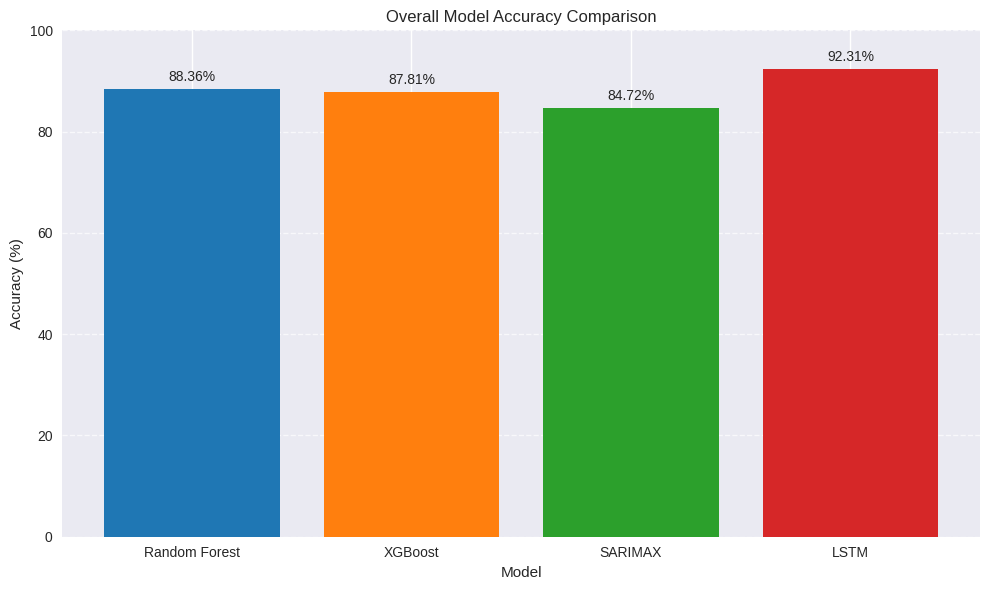

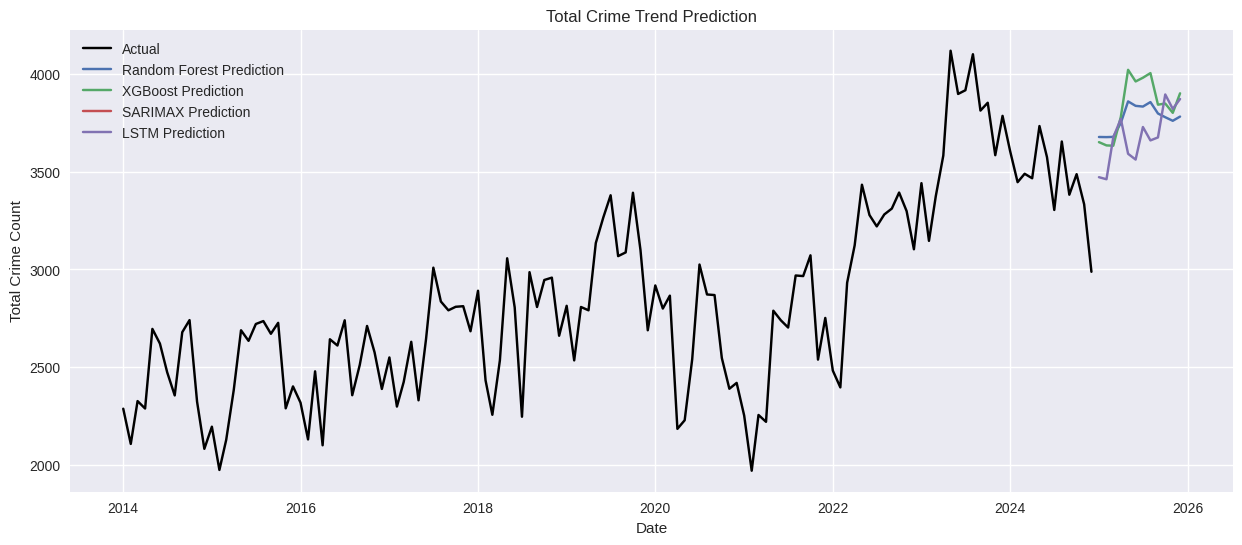

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive

# Mount Google Drive
# drive.mount('/content/drive', force_remount=True)

# Read the dataset
file_path = '/content/drive/MyDrive/ADT_Project/modified_dataset.csv'
df = pd.read_csv(file_path)

# Ensure months are in correct order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df['OCC_MONTH'] = pd.Categorical(df['OCC_MONTH'], categories=month_order, ordered=True)

# Convert OCC_YEAR to integer
df['OCC_YEAR'] = df['OCC_YEAR'].astype(int)

# Create Date column
df['Date'] = pd.to_datetime(df['OCC_YEAR'].astype(str) + '-' +
                           df['OCC_MONTH'].astype(str).map(lambda x: f"{month_order.index(x)+1:02d}") + '-01')

# Aggregate data: Total crime counts per month
agg_data = df.groupby('Date').agg({'Mean Temp (°C)': 'mean', 'OBJECTID': 'count'}).rename(columns={'OBJECTID': 'Total Crime Count'})
crime_ts = agg_data['Total Crime Count']
temp_ts = agg_data['Mean Temp (°C)']

# Split data: Last 12 months for testing
train_data = crime_ts[:-12]
test_data = crime_ts[-12:]
train_temp = temp_ts[:-12]
test_temp = temp_ts[-12:]

# Prepare future data
last_date = crime_ts.index[-1]
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=12, freq='MS')
future_temp = temp_ts[-12:].mean()

# Store predictions and accuracies
predictions = {}
accuracies = {}

# Compute average total count for relative accuracy
avg_total_count = crime_ts.mean()

# 1. Random Forest
print("Training Random Forest...")
X_train = pd.DataFrame({'Year': train_data.index.year, 'Month': train_data.index.month, 'Temp': train_temp})
y_train = train_data
X_test = pd.DataFrame({'Year': test_data.index.year, 'Month': test_data.index.month, 'Temp': test_temp})
X_future = pd.DataFrame({'Year': future_dates.year, 'Month': future_dates.month, 'Temp': [future_temp] * 12})

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_test_pred = rf.predict(X_test)
rf_future_pred = rf.predict(X_future)
mae = mean_absolute_error(test_data, rf_test_pred)
accuracies['Random Forest'] = max(0, min(100, (1 - mae / avg_total_count) * 100))
predictions['Random Forest'] = pd.Series(rf_future_pred, index=future_dates)

# 2. XGBoost
print("Training XGBoost...")
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_test_pred = xgb_model.predict(X_test)
xgb_future_pred = xgb_model.predict(X_future)
mae = mean_absolute_error(test_data, xgb_test_pred)
accuracies['XGBoost'] = max(0, min(100, (1 - mae / avg_total_count) * 100))
predictions['XGBoost'] = pd.Series(xgb_future_pred, index=future_dates)

# 3. SARIMAX
print("Training SARIMAX...")
model = SARIMAX(train_data, exog=train_temp, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit(disp=False)
sarimax_test_pred = results.predict(start=len(train_data), end=len(train_data)+11, exog=test_temp)
sarimax_future_pred = results.forecast(steps=12, exog=[future_temp] * 12)
mae = mean_absolute_error(test_data, sarimax_test_pred)
accuracies['SARIMAX'] = max(0, min(100, (1 - mae / avg_total_count) * 100))
predictions['SARIMAX'] = pd.Series(sarimax_future_pred, index=future_dates)

# 4. LSTM (Multi-Step Prediction)
print("Training LSTM...")
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(pd.DataFrame({'Temp': temp_ts, 'Year': crime_ts.index.year, 'Month': crime_ts.index.month}))
y_scaled = scaler_y.fit_transform(crime_ts.values.reshape(-1, 1))

sequence_length = 12
X_lstm, y_lstm = [], []
for i in range(sequence_length, len(X_scaled) - 11):  # Prepare for 12-step output
    X_lstm.append(X_scaled[i-sequence_length:i])
    y_lstm.append(y_scaled[i:i+12])  # 12 future steps
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

train_size = len(X_lstm) - 1  # Adjust for 12-step prediction
X_train, X_test = X_lstm[:train_size], X_lstm[train_size:train_size+1]
y_train, y_test = y_lstm[:train_size], y_lstm[train_size:train_size+1]

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, X_train.shape[2]), return_sequences=False))
model.add(Dense(12))  # Output 12 steps
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

lstm_test_pred = scaler_y.inverse_transform(model.predict(X_test, verbose=0))[0]
X_future = np.array([X_scaled[-sequence_length:]])
lstm_future_pred = scaler_y.inverse_transform(model.predict(X_future, verbose=0))[0]
mae = mean_absolute_error(test_data, lstm_test_pred)
accuracies['LSTM'] = max(0, min(100, (1 - mae / avg_total_count) * 100))
predictions['LSTM'] = pd.Series(lstm_future_pred, index=future_dates)

# Display Accuracies
print("\nAverage Monthly Total Crime Count:", avg_total_count)
print("\nOverall Accuracy (%) for Each Model:")
for model, accuracy in accuracies.items():
    print(f"{model}: {accuracy:.2f}%")

# Generate Bar Graph
models = list(accuracies.keys())
accuracy_values = list(accuracies.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracy_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Overall Model Accuracy Comparison')
plt.ylim(0, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add accuracy values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Plotting Predictions vs Actual
plt.figure(figsize=(15, 6))
plt.plot(crime_ts.index, crime_ts, label='Actual', color='black')
for model_name, pred in predictions.items():
    plt.plot(pred.index, pred, label=f'{model_name} Prediction')
plt.title('Total Crime Trend Prediction')
plt.xlabel('Date')
plt.ylabel('Total Crime Count')
plt.legend()
plt.grid(True)
plt.show()

8) Prediction Using LSTM for each and every category for 3 Years

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.2242
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2077
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1745
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1226
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0760
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0687
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0477
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0495
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0462
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0450
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0462
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0445
Epoch 13/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0432
Epoch 14/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0439
Epoch 15/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0418
Epoch 16/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.4082
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3934
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3788
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3623
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3429
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3199
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2877
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2454
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1876
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1320
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1380
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1051
Epoch 13/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0908
Epoch 14/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0886
Epoch 15/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0808
Epoch 16/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/

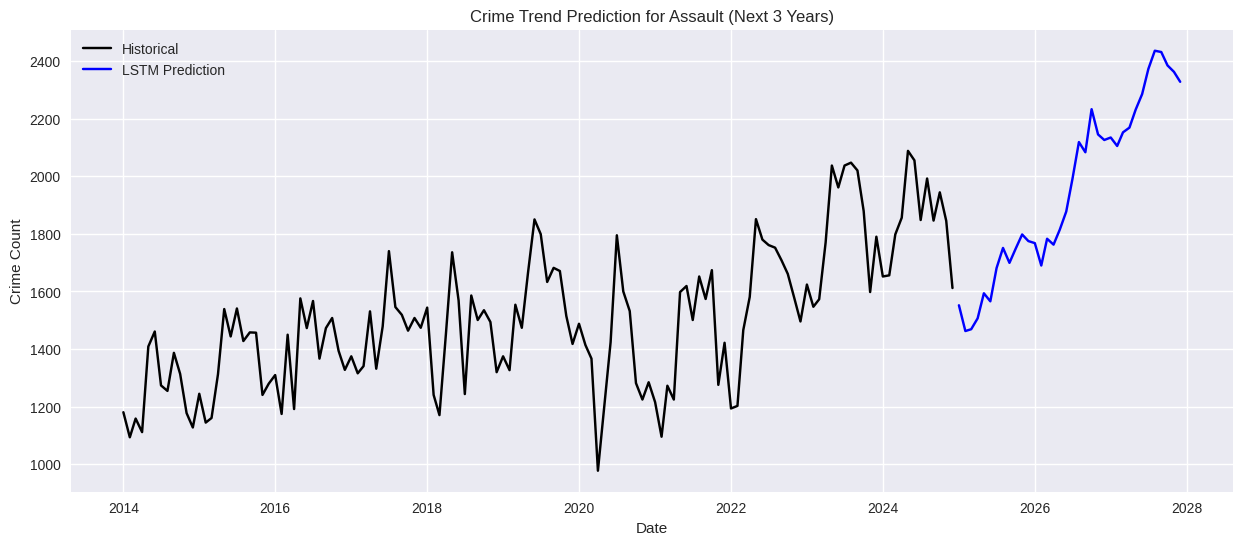

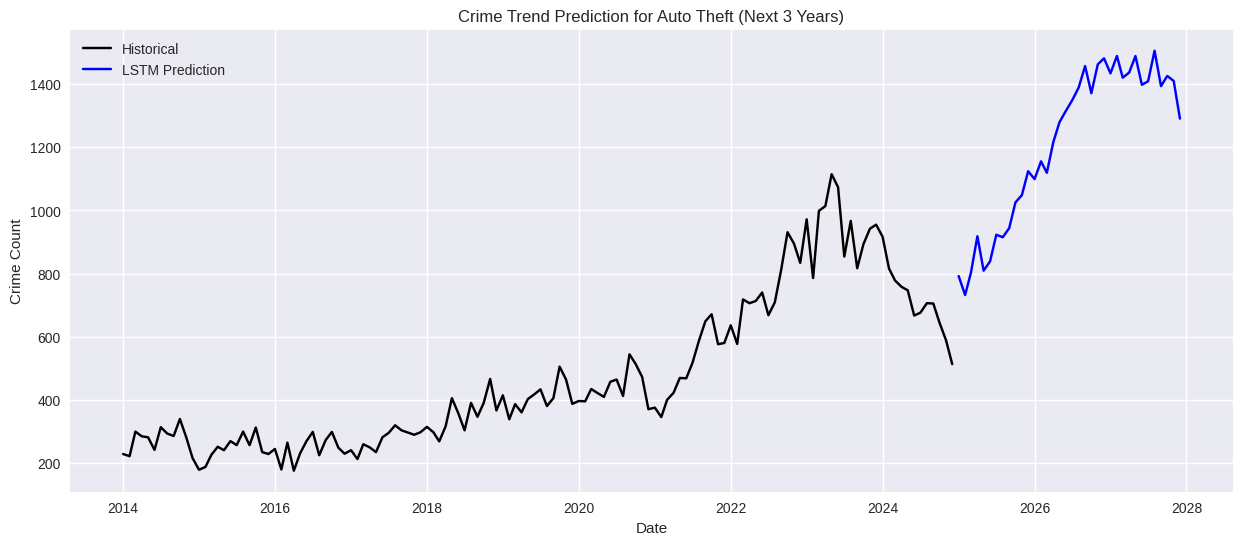

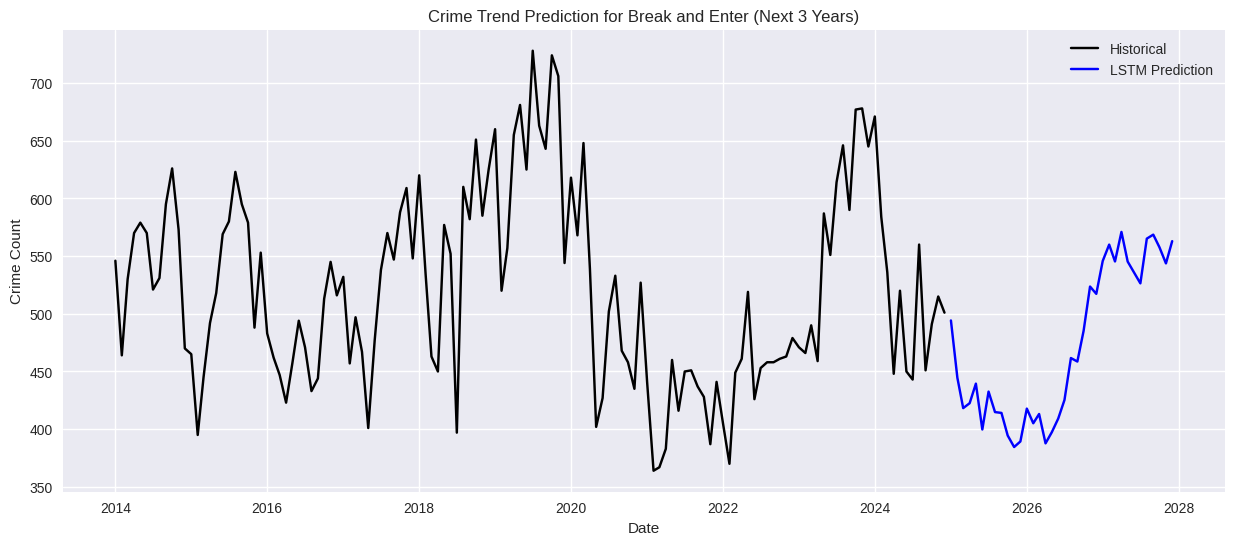

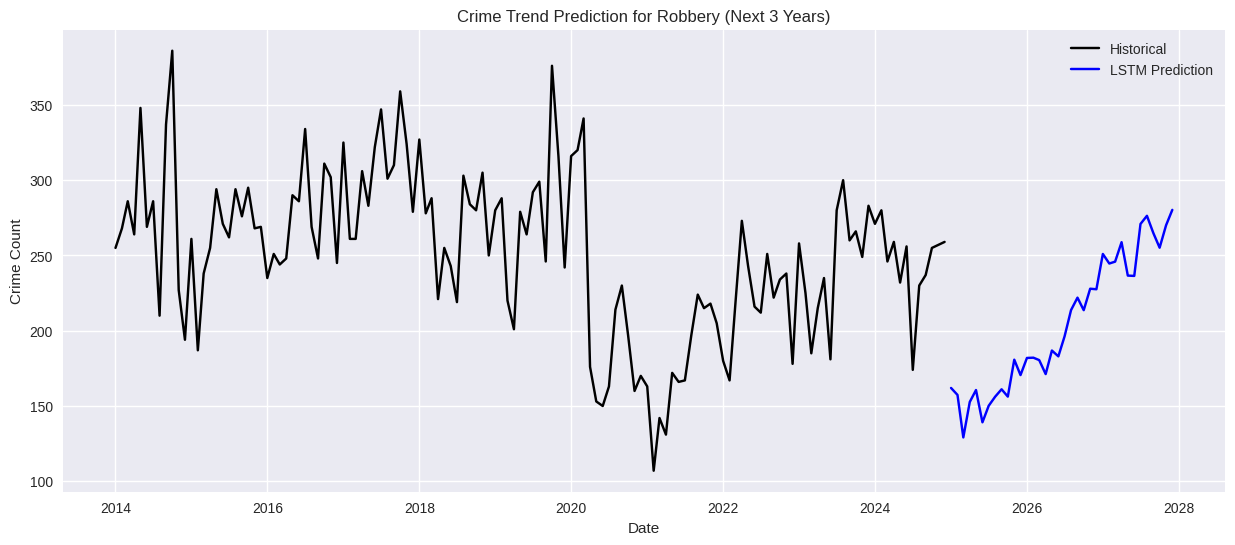

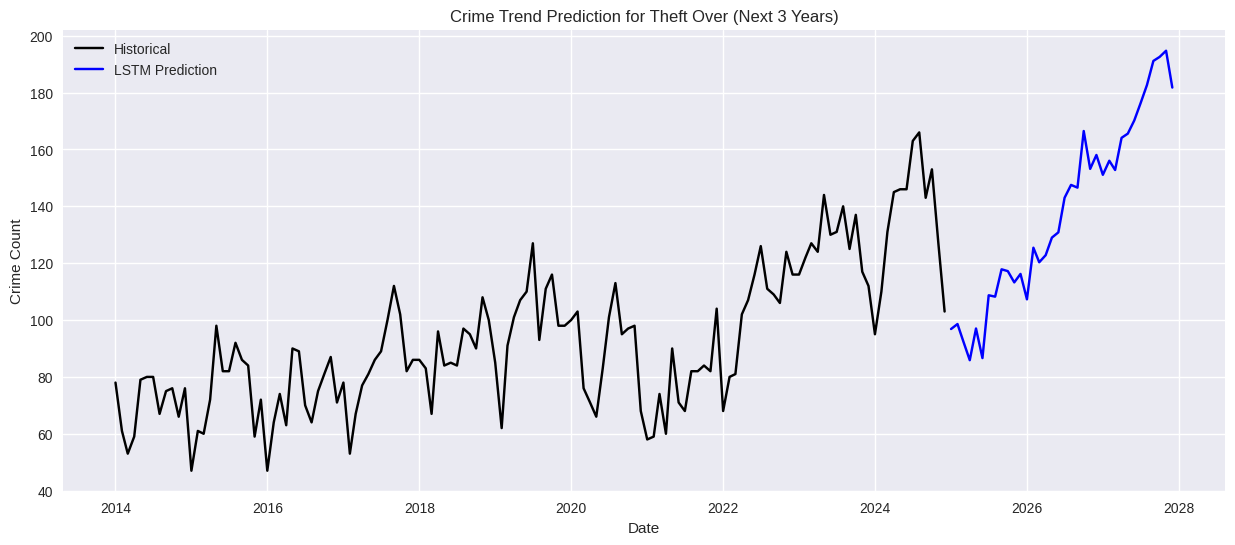

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive

# Mount Google Drive
# drive.mount('/content/drive', force_remount=True)

# Read the dataset
file_path = '/content/drive/MyDrive/ADT_Project/modified_dataset.csv'
df = pd.read_csv(file_path)

# Ensure months are in correct order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df['OCC_MONTH'] = pd.Categorical(df['OCC_MONTH'], categories=month_order, ordered=True)

# Convert OCC_YEAR to integer
df['OCC_YEAR'] = df['OCC_YEAR'].astype(int)

# Create Date column
df['Date'] = pd.to_datetime(df['OCC_YEAR'].astype(str) + '-' +
                           df['OCC_MONTH'].astype(str).map(lambda x: f"{month_order.index(x)+1:02d}") + '-01')

# Aggregate data: Monthly crime counts per category, temperature, and season
agg_data = df.groupby(['Date', 'MCI_CATEGORY']).agg({'Mean Temp (°C)': 'mean', 'OBJECTID': 'count', 'Season': 'first'}).rename(columns={'OBJECTID': 'Crime Count'}).reset_index()
crime_ts = agg_data.pivot(index='Date', columns='MCI_CATEGORY', values='Crime Count').fillna(0)
temp_ts = agg_data.groupby('Date')['Mean Temp (°C)'].mean()
season_ts = agg_data.groupby('Date')['Season'].first()

# Prepare future dates (next 36 months = 3 years)
last_date = crime_ts.index[-1]
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=36, freq='MS')

# Assume future temperature and season repeat last 12 months' pattern
last_year_temp = temp_ts[-12:].values
future_temp = np.tile(last_year_temp, 3)
last_year_season = season_ts[-12:].values
future_season = np.tile(last_year_season, 3)

# Prepare data for LSTM (Crime Categories)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
features = pd.DataFrame({
    'Temp': temp_ts,
    'Year': crime_ts.index.year,
    'Month': crime_ts.index.month
})
X_scaled = scaler_X.fit_transform(features)
y_scaled = scaler_y.fit_transform(crime_ts)

# Create sequences for LSTM
sequence_length = 12
future_steps = 36
X_lstm, y_lstm = [], []
for i in range(sequence_length, len(X_scaled) - future_steps + 1):
    X_lstm.append(X_scaled[i-sequence_length:i])
    y_lstm.append(y_scaled[i:i+future_steps])  # 36 future steps
X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)  # Shape: (samples, 36, 5)

# Train LSTM for crime categories
model_crime = Sequential()
model_crime.add(LSTM(100, activation='relu', input_shape=(sequence_length, X_lstm.shape[2]), return_sequences=True))
model_crime.add(LSTM(50, activation='relu', return_sequences=False))
model_crime.add(Dense(future_steps * len(crime_ts.columns)))  # Output 36 steps x 5 categories
model_crime.add(Dense(future_steps * len(crime_ts.columns)))  # Dense layer for flexibility
model_crime.compile(optimizer='adam', loss='mse')

# Reshape y_lstm for training (flatten the last two dimensions)
y_lstm_flat = y_lstm.reshape(y_lstm.shape[0], -1)  # (samples, 36*5)
model_crime.fit(X_lstm, y_lstm_flat, epochs=50, batch_size=32, verbose=1)

# Predict future crime trends
X_future = np.array([X_scaled[-sequence_length:]])
future_pred_flat = model_crime.predict(X_future, verbose=0)  # Shape: (1, 36*5)
future_pred = future_pred_flat.reshape(future_steps, len(crime_ts.columns))  # Shape: (36, 5)
future_pred = scaler_y.inverse_transform(future_pred)
crime_predictions = pd.DataFrame(future_pred, index=future_dates, columns=crime_ts.columns)

# Train LSTM for temperature
temp_y_scaled = scaler_y.fit_transform(temp_ts.values.reshape(-1, 1))
X_temp_lstm, y_temp_lstm = [], []
for i in range(sequence_length, len(X_scaled) - future_steps + 1):
    X_temp_lstm.append(X_scaled[i-sequence_length:i])
    y_temp_lstm.append(temp_y_scaled[i:i+future_steps])
X_temp_lstm = np.array(X_temp_lstm)
y_temp_lstm = np.array(y_temp_lstm)  # Shape: (samples, 36, 1)

model_temp = Sequential()
model_temp.add(LSTM(50, activation='relu', input_shape=(sequence_length, X_temp_lstm.shape[2]), return_sequences=False))
model_temp.add(Dense(future_steps))  # 36 steps for temperature
model_temp.compile(optimizer='adam', loss='mse')
model_temp.fit(X_temp_lstm, y_temp_lstm[:, :, 0], epochs=50, batch_size=32, verbose=1)  # Use last dimension

# Plotting Crime Trends by Category
for category in crime_ts.columns:
    plt.figure(figsize=(15, 6))
    plt.plot(crime_ts.index, crime_ts[category], label='Historical', color='black')
    plt.plot(crime_predictions.index, crime_predictions[category], label='LSTM Prediction', color='blue')
    plt.title(f'Crime Trend Prediction for {category} (Next 3 Years)')
    plt.xlabel('Date')
    plt.ylabel('Crime Count')
    plt.legend()
    plt.grid(True)
    plt.show()


9) Prediction Using LSTM for each and every category for 3 Years with weather data

Training LSTM for Assault...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training LSTM for Auto Theft...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training LSTM for Break and Enter...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training LSTM for Robbery...
Training LSTM for Theft Over...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


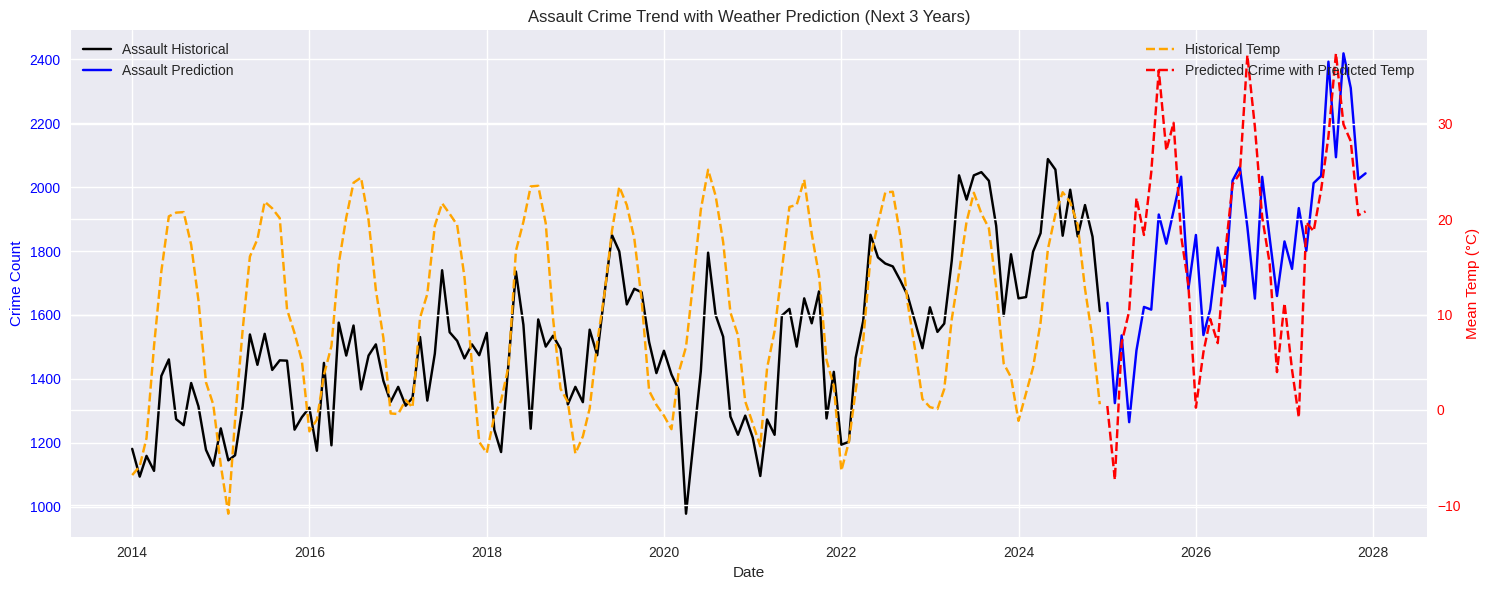

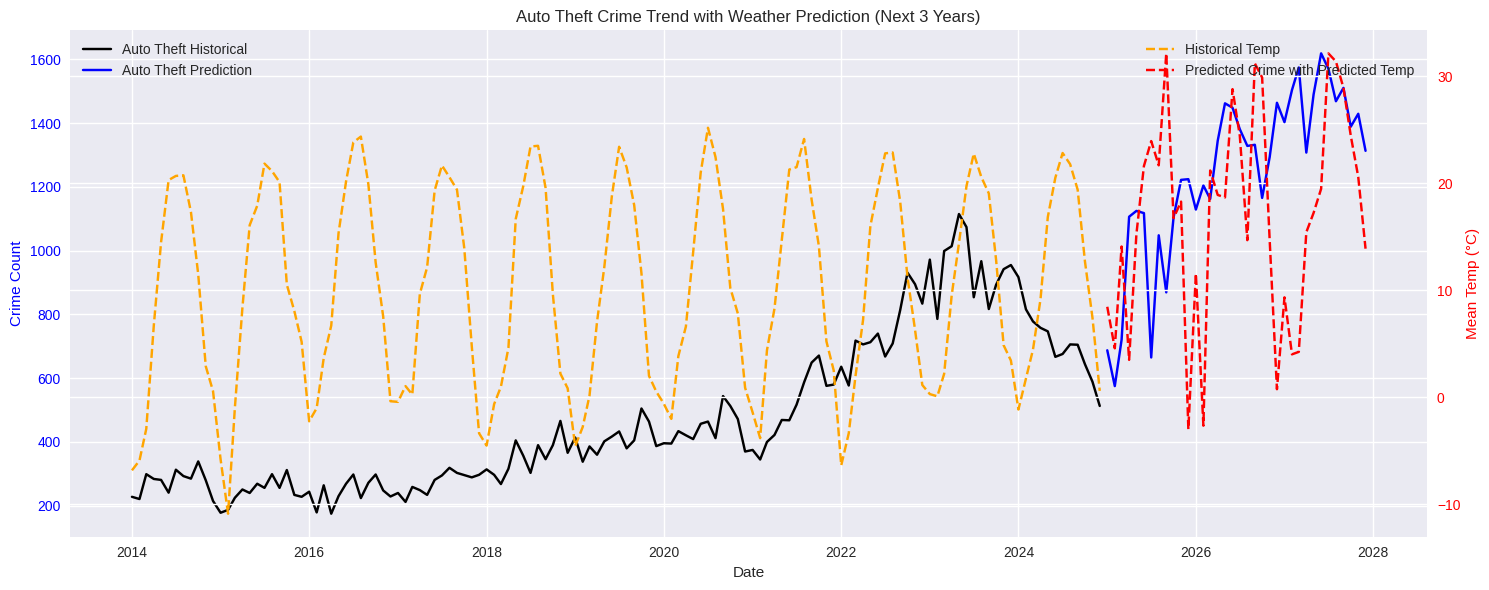

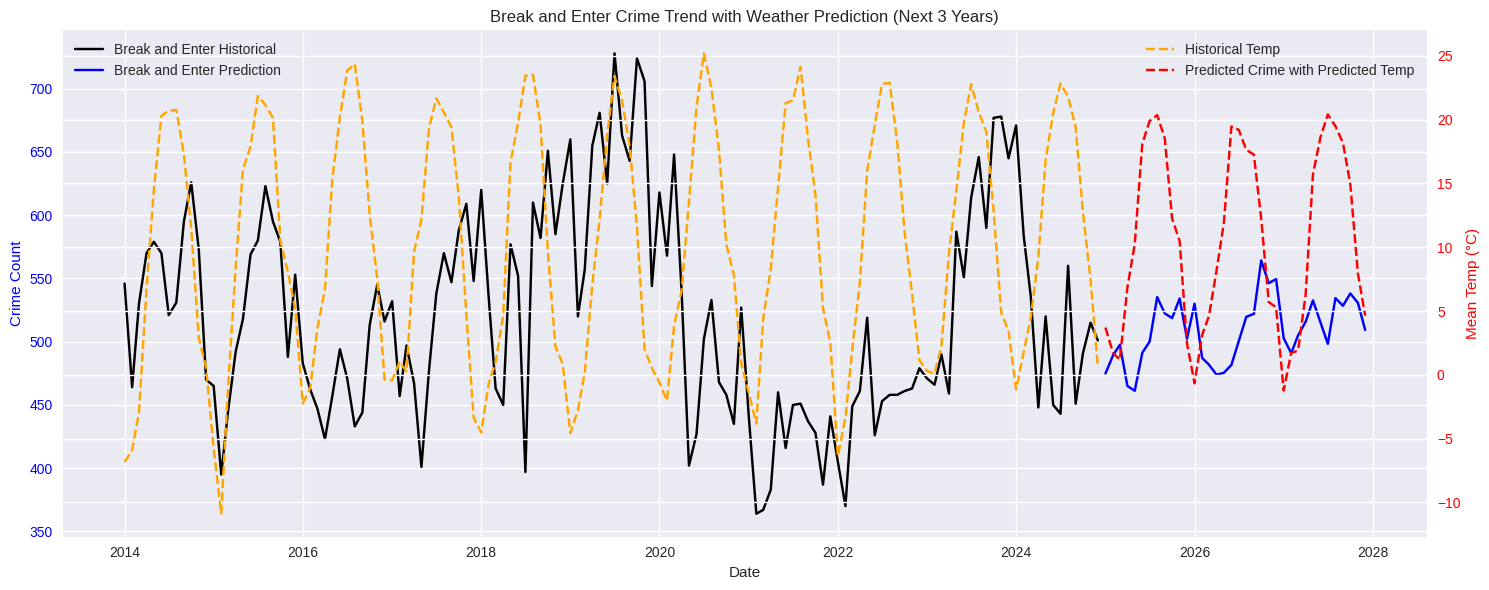

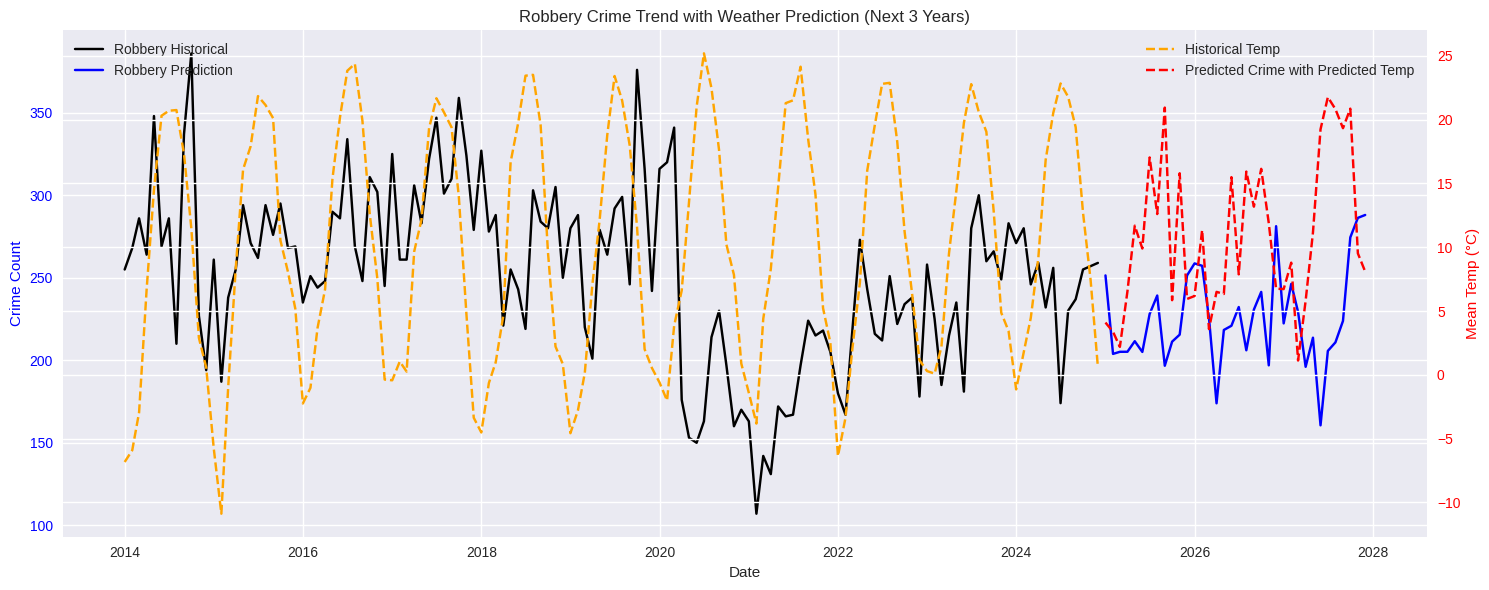

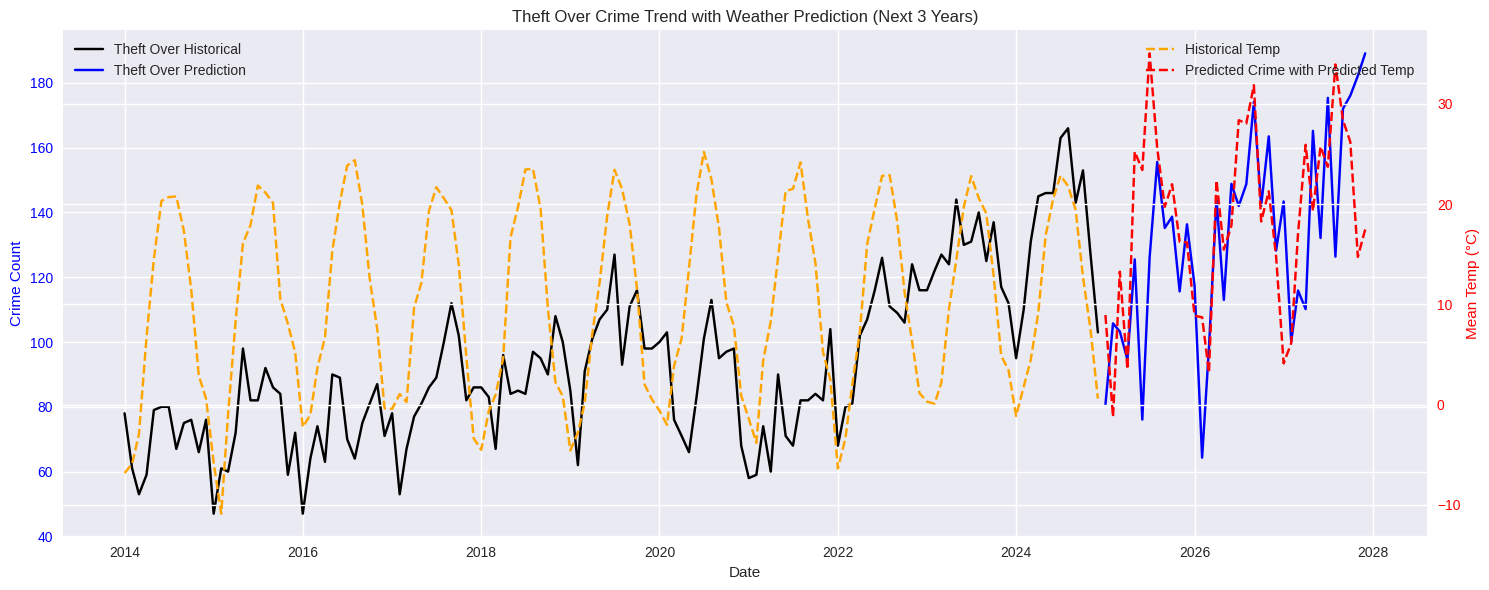

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive

# Mount Google Drive
# drive.mount('/content/drive', force_remount=True)

# Read the dataset
file_path = '/content/drive/MyDrive/ADT_Project/modified_dataset.csv'
df = pd.read_csv(file_path)

# Ensure months are in correct order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df['OCC_MONTH'] = pd.Categorical(df['OCC_MONTH'], categories=month_order, ordered=True)

# Convert OCC_YEAR to integer
df['OCC_YEAR'] = df['OCC_YEAR'].astype(int)

# Create Date column
df['Date'] = pd.to_datetime(df['OCC_YEAR'].astype(str) + '-' +
                           df['OCC_MONTH'].astype(str).map(lambda x: f"{month_order.index(x)+1:02d}") + '-01')

# Aggregate data: Monthly crime counts per category and temperature
agg_data = df.groupby(['Date', 'MCI_CATEGORY']).agg({'Mean Temp (°C)': 'mean', 'OBJECTID': 'count'}).rename(columns={'OBJECTID': 'Crime Count'}).reset_index()
crime_ts = agg_data.pivot(index='Date', columns='MCI_CATEGORY', values='Crime Count').fillna(0)
temp_ts = agg_data.groupby('Date')['Mean Temp (°C)'].mean()

# Prepare future dates (next 36 months = 3 years)
last_date = crime_ts.index[-1]
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=36, freq='MS')

# Assume future temperature repeats last 12 months' pattern
last_year_temp = temp_ts[-12:].values
future_temp = np.tile(last_year_temp, 3)

# Function to prepare LSTM data for a single category
def prepare_lstm_data(crime_series, temp_series, sequence_length, future_steps):
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    features = pd.DataFrame({
        'Temp': temp_series,
        'Year': crime_series.index.year,
        'Month': crime_series.index.month
    })
    X_scaled = scaler_X.fit_transform(features)
    y_combined = np.column_stack((crime_series.values, temp_series.values))
    y_scaled = scaler_y.fit_transform(y_combined)

    X_lstm, y_lstm = [], []
    for i in range(sequence_length, len(X_scaled) - future_steps + 1):
        X_lstm.append(X_scaled[i-sequence_length:i])
        y_lstm.append(y_scaled[i:i+future_steps])
    return np.array(X_lstm), np.array(y_lstm), scaler_X, scaler_y

# Predict for each category
sequence_length = 12
future_steps = 36
crime_predictions = {}
temp_predictions = {}

for category in crime_ts.columns:
    print(f"Training LSTM for {category}...")
    X_lstm, y_lstm, scaler_X, scaler_y = prepare_lstm_data(crime_ts[category], temp_ts, sequence_length, future_steps)

    # Train LSTM
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(sequence_length, X_lstm.shape[2]), return_sequences=True))
    model.add(LSTM(50, activation='relu', return_sequences=False))
    model.add(Dense(future_steps * 2))  # 36 steps x (crime + temp)
    model.compile(optimizer='adam', loss='mse')
    y_lstm_flat = y_lstm.reshape(y_lstm.shape[0], -1)  # Flatten for training
    model.fit(X_lstm, y_lstm_flat, epochs=50, batch_size=32, verbose=0)

    # Predict future trends
    X_future = np.array([scaler_X.transform(pd.DataFrame({
        'Temp': future_temp[:sequence_length],
        'Year': crime_ts.index[-sequence_length:].year,
        'Month': crime_ts.index[-sequence_length:].month
    }))])
    future_pred_flat = model.predict(X_future, verbose=0)
    future_pred = future_pred_flat.reshape(future_steps, 2)  # Reshape to (36, 2)
    future_pred = scaler_y.inverse_transform(future_pred)

    crime_predictions[category] = pd.Series(future_pred[:, 0], index=future_dates)
    temp_predictions[category] = pd.Series(future_pred[:, 1], index=future_dates)

# Plotting Crime Trends with Weather by Category
for category in crime_ts.columns:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    # Plot crime count (left y-axis)
    ax1.plot(crime_ts.index, crime_ts[category], label=f'{category} Historical', color='black')
    ax1.plot(crime_predictions[category].index, crime_predictions[category], label=f'{category} Prediction', color='blue')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Crime Count', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(loc='upper left')

    # Plot temperature (right y-axis)
    ax2 = ax1.twinx()
    ax2.plot(temp_ts.index, temp_ts, label='Historical Temp', color='orange', linestyle='--')
    ax2.plot(temp_predictions[category].index, temp_predictions[category], label='Predicted Crime with Predicted Temp', color='red', linestyle='--')
    ax2.set_ylabel('Mean Temp (°C)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.legend(loc='upper right')

    plt.title(f'{category} Crime Trend with Weather Prediction (Next 3 Years)')
    plt.grid(True)
    fig.tight_layout()
    plt.show()

10) Interactive heatmap with all crime categories

In [ ]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap
from google.colab import drive

# Mount Google Drive (uncomment if needed)
# drive.mount('/content/drive', force_remount=True)

# Read the dataset
file_path = '/content/drive/MyDrive/ADT_Project/modified_dataset.csv'
df = pd.read_csv(file_path)

# Ensure months are in correct order (for consistency, even if not used directly here)
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df['OCC_MONTH'] = pd.Categorical(df['OCC_MONTH'], categories=month_order, ordered=True)

# Convert OCC_YEAR to integer
df['OCC_YEAR'] = df['OCC_YEAR'].astype(int)

# --- Heatmap Generation ---

# Check if spatial data exists
if 'LAT_WGS84' not in df.columns or 'LONG_WGS84' not in df.columns:
    print("Error: Dataset lacks LAT_WGS84 and LONG_WGS84 columns. Please add spatial data.")
    raise KeyError("Missing spatial columns")

# Bin temperatures into categories
temp_bins = [-float('inf'), 0, 10, 20, float('inf')]
temp_labels = ['Cold (<0°C)', 'Mild (0-10°C)', 'Warm (10-20°C)', 'Hot (>20°C)']
df['Temp_Category'] = pd.cut(df['Mean Temp (°C)'], bins=temp_bins, labels=temp_labels)

# Aggregate crime counts by location, category, and temperature (no season)
spatial_data = df.groupby(['MCI_CATEGORY', 'Temp_Category', 'LAT_WGS84', 'LONG_WGS84'], observed=True).agg({'OBJECTID': 'count'}).rename(columns={'OBJECTID': 'Crime Count'}).reset_index()

# Toronto coordinates (center of the city)
toronto_center = [43.70, -79.42]

# Get unique crime categories
crime_categories = df['MCI_CATEGORY'].unique()

# Create a single base map
m = folium.Map(location=toronto_center, zoom_start=11, tiles='OpenStreetMap')

# Generate feature groups for each combination of crime and temperature
for category in crime_categories:
    for temp_cat in temp_labels:
        # Create a unique layer name
        layer_name = f"{category} - {temp_cat}"

        # Filter data for this combination
        subset = spatial_data[(spatial_data['MCI_CATEGORY'] == category) &
                              (spatial_data['Temp_Category'] == temp_cat)]
        if subset.empty:
            print(f"No data for {layer_name}")
            continue

        # Create a feature group for this specific combination
        fg = folium.FeatureGroup(name=layer_name, show=False)  # Hidden by default

        # Prepare heatmap data: [lat, lon, weight]
        heat_data = subset[['LAT_WGS84', 'LONG_WGS84', 'Crime Count']].values.tolist()

        # Add heatmap layer to the feature group
        HeatMap(heat_data, radius=15, blur=20, max_zoom=13).add_to(fg)

        # Add the feature group to the map
        fg.add_to(m)

# Add layer control to toggle between all layers
folium.LayerControl(collapsed=False).add_to(m)

# Save the single interactive map to an HTML file
output_file = '/content/interactive_heatmap_all_crimes.html'
m.save(output_file)
print(f"Interactive heatmap with all crime categories saved: {output_file}")

Interactive heatmap with all crime categories saved: /content/interactive_heatmap_all_crimes.html


11) Dashboard

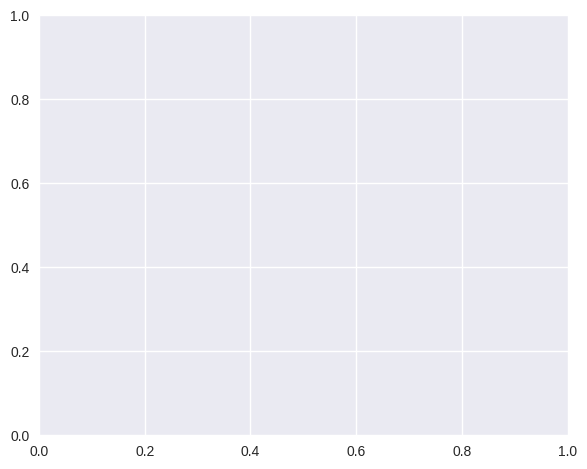

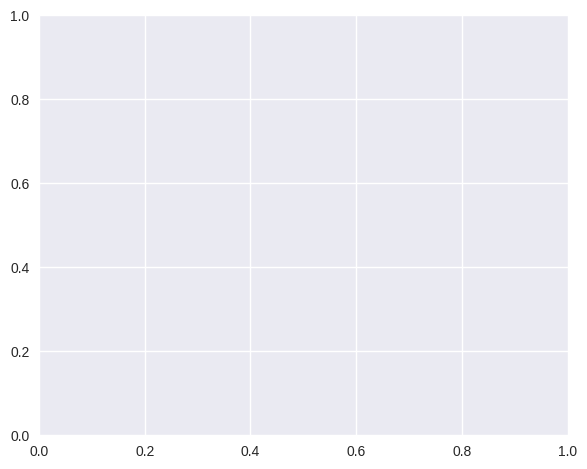

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from google.colab import files

# Read the dataset
file_path = '/content/drive/MyDrive/ADT_Project/modified_dataset.csv'
df = pd.read_csv(file_path)

# Ensure months are in correct order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df['OCC_MONTH'] = pd.Categorical(df['OCC_MONTH'], categories=month_order, ordered=True)
df['OCC_YEAR'] = df['OCC_YEAR'].astype(int)

# Add Season and Overall Temp columns (from your first cell)
def get_season(month):
    if month in ['June', 'July', 'August']:
        return 'Summer'
    elif month in ['September', 'October', 'November']:
        return 'Fall'
    else:  # December to May
        return 'Winter'

def get_temp_category(mean_temp):
    if mean_temp < 0:
        return 'Cold'
    elif 0 <= mean_temp <= 15:
        return 'Average'
    else:  # > 15
        return 'Hot'

df['Season'] = df['OCC_MONTH'].apply(get_season)
df['Overall Temp'] = df['Mean Temp (°C)'].apply(get_temp_category)

# For heatmap: Bin temperatures into more detailed categories
temp_bins = [-float('inf'), 0, 10, 20, float('inf')]
temp_labels = ['Cold (<0°C)', 'Mild (0-10°C)', 'Warm (10-20°C)', 'Hot (>20°C)']
df['Temp_Category'] = pd.cut(df['Mean Temp (°C)'], bins=temp_bins, labels=temp_labels)

# Aggregate spatial data for heatmap
spatial_data = df.groupby(['MCI_CATEGORY', 'Temp_Category', 'LAT_WGS84', 'LONG_WGS84'], observed=True).agg({'OBJECTID': 'count'}).rename(columns={'OBJECTID': 'Crime Count'}).reset_index()

# Unique values for dropdowns
crime_categories = df['MCI_CATEGORY'].unique().tolist()
seasons = df['Season'].unique().tolist()
temp_categories = temp_labels

# --- Dashboard Setup ---

# Widgets
crime_dropdown = widgets.Dropdown(options=['All'] + crime_categories, value='All', description='Crime Category:')
season_dropdown = widgets.Dropdown(options=['All'] + seasons, value='All', description='Season:')
temp_dropdown = widgets.Dropdown(options=['All'] + temp_categories, value='All', description='Temp Category:')
update_button = widgets.Button(description='Update Dashboard')

# Output area
output = widgets.Output()

# Function to generate heatmap and save to HTML
def generate_heatmap(selected_category):
    toronto_center = [43.70, -79.42]
    m = folium.Map(location=toronto_center, zoom_start=11, tiles='OpenStreetMap')

    for category in crime_categories:
        if selected_category != 'All' and category != selected_category:
            continue
        for temp_cat in temp_labels:
            subset = spatial_data[(spatial_data['MCI_CATEGORY'] == category) &
                                  (spatial_data['Temp_Category'] == temp_cat)]
            if subset.empty:
                continue
            layer_name = f"{category} - {temp_cat}"
            fg = folium.FeatureGroup(name=layer_name, show=False)
            heat_data = subset[['LAT_WGS84', 'LONG_WGS84', 'Crime Count']].values.tolist()
            HeatMap(heat_data, radius=15, blur=20, max_zoom=13).add_to(fg)
            fg.add_to(m)

    folium.LayerControl(collapsed=False).add_to(m)
    m.save('/content/temp_heatmap.html')
    return '/content/temp_heatmap.html'

# Dashboard update function
def update_dashboard(change):
    with output:
        clear_output()

        # Filter data based on selections
        filtered_df = df.copy()
        if crime_dropdown.value != 'All':
            filtered_df = filtered_df[filtered_df['MCI_CATEGORY'] == crime_dropdown.value]
        if season_dropdown.value != 'All':
            filtered_df = filtered_df[filtered_df['Season'] == season_dropdown.value]
        if temp_dropdown.value != 'All':
            filtered_df = filtered_df[filtered_df['Temp_Category'] == temp_dropdown.value]

        # Plotting
        plt.style.use('seaborn-v0_8')
        fig = plt.figure(figsize=(15, 12))

        # Plot 1: Crime vs Season Heatmap
        plt.subplot(2, 2, 1)
        crime_season = pd.crosstab(filtered_df['MCI_CATEGORY'], filtered_df['Season'])
        sns.heatmap(crime_season, annot=True, fmt='d', cmap='YlOrRd')
        plt.title('Crime Categories vs Season')
        plt.xlabel('Season')
        plt.ylabel('Crime Category')

        # Plot 2: Crime vs Temperature Heatmap
        plt.subplot(2, 2, 2)
        crime_temp = pd.crosstab(filtered_df['MCI_CATEGORY'], filtered_df['Overall Temp'])
        sns.heatmap(crime_temp, annot=True, fmt='d', cmap='YlOrRd')
        plt.title('Crime Categories vs Temperature')
        plt.xlabel('Temperature Category')
        plt.ylabel('Crime Category')

        # Plot 3: Crime Distribution by Season
        plt.subplot(2, 2, 3)
        sns.countplot(data=filtered_df, x='MCI_CATEGORY', hue='Season')
        plt.title('Crime Distribution by Season')
        plt.xlabel('Crime Category')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.legend(title='Season')

        # Plot 4: Crime Distribution by Temperature
        plt.subplot(2, 2, 4)
        sns.countplot(data=filtered_df, x='MCI_CATEGORY', hue='Overall Temp')
        plt.title('Crime Distribution by Temperature')
        plt.xlabel('Crime Category')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.legend(title='Temperature')

        plt.tight_layout()
        plt.show()

        # Correlation Analysis
        weather_correlation = filtered_df.groupby('MCI_CATEGORY').agg({'Mean Temp (°C)': 'mean', 'OBJECTID': 'count'}).rename(columns={'OBJECTID': 'Count'}).reset_index()
        correlation = weather_correlation['Mean Temp (°C)'].corr(weather_correlation['Count'])
        print(f"Correlation between Mean Temperature and Crime Count: {correlation:.3f}")

        # Frequency Analysis
        print("\nCrime Frequency by Season (%):")
        print(filtered_df['Season'].value_counts(normalize=True) * 100)
        print("\nCrime Frequency by Temperature Category (%):")
        print(filtered_df['Overall Temp'].value_counts(normalize=True) * 100)

        # Generate and display heatmap
        heatmap_file = generate_heatmap(crime_dropdown.value)
        with open(heatmap_file, 'r') as f:
            heatmap_html = f.read()
        display(HTML(f"<h3>Interactive Heatmap</h3><iframe srcdoc='{heatmap_html}' width='100%' height='500'></iframe>"))

# Link button to update function
update_button.on_click(update_dashboard)

# Display dashboard
display(widgets.VBox([crime_dropdown, season_dropdown, temp_dropdown, update_button, output]))
update_dashboard(None)  # Initial display